In [1]:
import os
import SimpleITK as sitk
import six
from radiomics import featureextractor as fe
import radiomics
import nibabel as nib 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import scipy
import pandas as pd
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from matplotlib.figure import Figure
import package_outlier as po
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import pearsonr

In [2]:
def nii_to_arr(nii_file):
    sitk_img = sitk.ReadImage(nii_file)
    origin = sitk_img.GetOrigin()
    spacing = sitk_img.GetSpacing()
    assert(spacing[2] == 12.)
    arr = sitk.GetArrayFromImage(sitk_img)
    
    return origin, spacing, arr

In [3]:
def extract_chamber(segmentation_file, intensity):
    origin, spacing, img_arr = nii_to_arr(segmentation_file)
    assert(spacing[2] == 12.)
    img_arr_roi = np.where(img_arr == intensity, 1., 0.)
    return origin, spacing, img_arr_roi

def extract_voxel(nii_file):
    sitk_img = sitk.ReadImage(nii_file)
    assert(sitk_img.GetSpacing()[2])
    return sitk_img.GetSpacing()[0]*sitk_img.GetSpacing()[1]*sitk_img.GetSpacing()[2]

In [4]:
def chamber_vol_func(patient_id, num_images, t_start, nnunet_images_prefix):

    nnunet_folder = nnunet_path + 'EXH' + patient_id + '/REST/z_12/all_slices/'

    for comp in ['LV','LVMC']:
        vol = []
        t_end = t_start + num_images
        for t in range(t_start,t_end):
            rest_maskName = nnunet_folder + nnunet_images_prefix + str(t).zfill(4) + nnunet_images_suffix
            origin, spacing, rest_chamber = extract_chamber(rest_maskName, chamber_intensity[comp])    
            voxel_vol = extract_voxel(rest_maskName)
            vol.append(np.sum(rest_chamber)*voxel_vol)
        chamber_volume_nnunet[comp] = vol
    return chamber_volume_nnunet

In [5]:
chamber_volume_nnunet = {}
chamber_intensity = {'LV': 3.,
                    'LVMC': 2., 
                    }

In [6]:
nnunet_path = '/Users/saurabh/sample/uh_images/'

#### Plot volume vs time

In [7]:
nnunet_images_suffix = '.nii.gz'

def plot_vol_vs_time(patient_id):

    nnunet_folder = nnunet_path + 'EXH' + patient_id + '/REST/z_12/all_slices/'
    nnunet_images_prefix = 'EXH' + patient_id + '_CINE_SET-UP-8SAX-1RTVLA-1HLA_'

    if patient_id == '100B':
        nnunet_images_prefix = 'EXH' + patient_id + '_CINE_SET-UP-8SAX-1VLA-1HLA_'

    num_images = len(glob.glob(nnunet_folder+'*.gz'))

    t_start = 0

    chamber_volume_nnunet = chamber_vol_func(patient_id, num_images, t_start, nnunet_images_prefix)
    plt.scatter(np.arange(num_images),chamber_volume_nnunet['LV'],label='LV')
    plt.scatter(np.arange(num_images),chamber_volume_nnunet['LVMC'],label='LVMC')
    #plt.xlim(0,11)
    plt.legend();

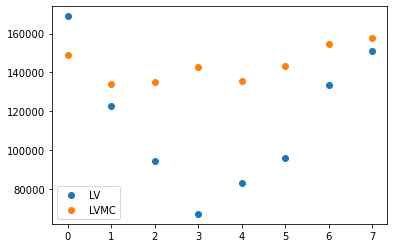

In [8]:
plot_vol_vs_time('175')

### Volume Features

In [8]:
path = os.getcwd()
path

'/Users/saurabh/Desktop/HeartProjects/Exhalted/Params/Code_EXH'

In [10]:
vol_df = pd.read_csv('vol.csv')
vol_df.drop(columns='Unnamed: 0',inplace=True);
vol_df.head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
0,153,1362.454538,19.772862,78788.250000,85015.500000,85489.312500,73305.562500,0,0.142518,7965.467931,3.028929,39664.875000,106269.375000,66604.500000,0.626752
1,154,1170.807087,26.140431,109586.062500,103155.750000,109586.062500,94762.500000,1,0.135269,9425.673423,3.012396,46027.500000,130027.687500,84000.187500,0.646018
2,162,931.932994,27.155585,71613.375000,71071.875000,75674.625000,67416.750000,0,0.109123,4889.557224,4.245226,38920.312500,81428.062500,42507.750000,0.522028
3,191,628.804706,34.786485,113767.084884,103040.360091,114963.373894,103040.360091,0,0.103711,6097.426044,3.482814,58658.037807,151888.828014,93230.790206,0.613809
4,109,2522.159368,18.556770,111413.625000,126507.937500,135239.625000,111413.625000,0,0.176176,15817.902632,2.284888,42440.062500,153447.562500,111007.500000,0.723423


In [11]:
vol_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lvmc_std,57.0,1797.558352,978.553481,628.804706,1153.427697,1576.147548,2157.732959,5292.798928
lvmc_snr,57.0,23.563425,9.398134,6.777910,16.904342,21.800929,29.353887,51.752073
lvmc_vol_es,57.0,119454.560966,34094.778466,66739.875000,99432.937500,111481.312500,136187.250000,245279.123421
lvmc_vol_ed,57.0,117516.593433,26976.081444,65995.312500,101531.250000,113095.916148,131003.510365,200697.419636
lvmc_vol_max,57.0,127911.039980,32967.862905,71816.437500,109586.062500,122446.687500,143159.062500,249944.650562
lvmc_vol_min,57.0,108822.267145,27850.475428,59294.250000,91613.147363,106018.453125,128538.562500,200697.419636
lvmc_vol_es_equal_max,57.0,0.192982,0.398147,0.000000,0.000000,0.000000,0.000000,1.000000
lvmc_vol_max_minus_min,57.0,0.147485,0.058346,0.051396,0.107206,0.135528,0.180286,0.321380
lv_std,57.0,8757.182215,3055.657135,1293.227392,7026.437692,9064.454540,10607.786669,15817.902632
lv_snr,57.0,4.544664,3.082525,2.119069,3.227912,3.573549,4.431670,16.560371


In [37]:
vol_columns = vol_df.columns
numerical_columns = vol_columns.drop(['patient_id','lvmc_vol_es_equal_max']).values

In [38]:
vol_df.shape

(51, 15)

In [39]:
vol_df_scaled = vol_df.copy(deep=True)
vol_df_scaled[numerical_columns] = scaler.fit_transform(vol_df[numerical_columns])

#### Outlier analysis

Let's look at the outliers. The purpose of doing outlier analysis is to go back and check the raw images and do appropriate corrections on the segmentations if required. Low ejection fraction cases can be excluded from further analysis since it is a known cause of dyspnea. 

In [13]:
def outlier_func(df, numerical_columns, num_ouliers_min):
    '''
    Finds features with outliers
    '''
    outlier_features = []
    for feature in numerical_columns:
        outliers = po.ModifiedZscoreOutlier(df[feature].values)
        num_outliers = len(outliers)
        if num_outliers > num_ouliers_min:
            outlier_features.append(feature)
    return outlier_features

In [14]:
outlier_features = outlier_func(vol_df, numerical_columns, 3)
outlier_features

['lv_snr', 'stroke_volume', 'ejection_fraction']

<AxesSubplot:>

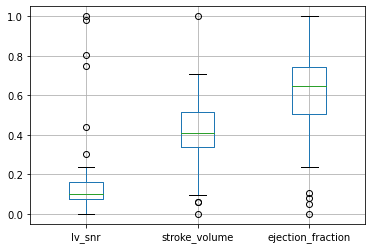

In [15]:
vol_df_scaled.boxplot(column = outlier_features[:])

In [17]:
feature = 'ejection_fraction'
outliers = po.ModifiedZscoreOutlier(vol_df[feature].values)
num_outliers = len(outliers)
print('number of outliers = ',num_outliers)

number of outliers =  4


In [18]:
vol_df.sort_values(by=[feature],ascending=True).head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
50,188,1153.427697,51.752073,138101.296538,131003.510365,138101.296538,131003.510365,1,0.051396,5913.262444,12.932917,148442.441956,182004.159358,33561.717402,0.184401
20,114,1034.658434,17.811026,85760.062500,100583.625000,100583.625000,82308.000000,0,0.181696,1293.227392,16.560371,92190.375000,117302.437500,25112.062500,0.214080
9,100B,2806.696077,11.717112,122988.187500,164616.000000,164616.000000,118114.687500,0,0.282484,2768.218732,16.263933,164954.437500,215178.562500,50224.125000,0.233407
12,123,632.677214,35.794174,104794.921875,103072.265625,112374.609375,99684.375000,0,0.112928,1969.364777,13.761918,102096.093750,136032.421875,33936.328125,0.249472
54,119,1790.748163,21.044772,137337.937500,135984.187500,155748.937500,133547.437500,0,0.142547,3033.372628,8.487487,78179.062500,116693.250000,38514.187500,0.330046


In [16]:
vol_df = vol_df.drop(index=50)

In [20]:
vol_df[vol_df['ejection_fraction'] < 0.4].sort_values(by=[feature],ascending=True)

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
20,114,1034.658434,17.811026,85760.062500,100583.625000,100583.625000,82308.0000,0,0.181696,1293.227392,16.560371,92190.37500,117302.437500,25112.062500,0.214080
9,100B,2806.696077,11.717112,122988.187500,164616.000000,164616.000000,118114.6875,0,0.282484,2768.218732,16.263933,164954.43750,215178.562500,50224.125000,0.233407
12,123,632.677214,35.794174,104794.921875,103072.265625,112374.609375,99684.3750,0,0.112928,1969.364777,13.761918,102096.09375,136032.421875,33936.328125,0.249472
54,119,1790.748163,21.044772,137337.937500,135984.187500,155748.937500,133547.4375,0,0.142547,3033.372628,8.487487,78179.06250,116693.250000,38514.187500,0.330046
48,111,1603.417244,15.159323,117975.000000,121875.000000,130275.000000,106575.0000,0,0.181923,3565.792521,6.507337,88800.00000,142875.000000,54075.000000,0.378478


In [17]:
low_lv_ef = vol_df[vol_df['ejection_fraction'] < 0.4].patient_id.values
low_lv_ef

array(['100B', '123', '114', '111', '119'], dtype=object)

In [18]:
vol_df = vol_df[~vol_df['patient_id'].isin(low_lv_ef)]
vol_df.shape

(51, 15)

In [19]:
cpet_file = path + '/ExerciseMRIEvaluatio_DATA_LABELS_2021-03-16_1304.xlsx'
cpet_data = pd.read_excel(cpet_file)

In [20]:
cpet_data.dropna(subset=['VO2 (MAX):'],inplace=True)
cpet_data.dropna(subset=['VO2 %Predicted '],inplace=True)
cpet_data.shape

(67, 662)

In [21]:
cpet_data.loc[cpet_data['VO2 %Predicted '] < 80., 'dyspnea'] = int(1)
cpet_data.loc[cpet_data['VO2 %Predicted '] >= 80., 'dyspnea'] = int(0)

In [22]:
Counter(cpet_data['dyspnea'])

Counter({1.0: 43, 0.0: 24})

In [26]:
cpet_data.columns.values

array(['Record ID', 'LV Ejection Fraction', 'VO2 %Predicted ', 'MRN',
       'Event Name', 'Date:',
       'Reviewed and subject acceptable for study?', 'HIV Positive?',
       'PAH Patient?', 'Complete?', 'Visit Number:',
       'Date and Time of ECG',
       'Heart Rhythm (check all that apply): (choice=normal sinus rhythm)',
       'Heart Rhythm (check all that apply): (choice=sinus tachycardia)',
       'Heart Rhythm (check all that apply): (choice=sinus bradycardia)',
       'Heart Rhythm (check all that apply): (choice=atrial arrhythmia)',
       'Heart Rhythm (check all that apply): (choice=ventricular arrhythmia)',
       'Heart Rhythm (check all that apply): (choice=other)',
       'ECG Results (choose only one):', 'Complete?.1', 'Date of echo',
       'Visit Number', 'Body surface area (BSA)',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Heart rate', 'Heart rate (peak)',
       '% of age predicted target heart rate', 'METS Achieved',
       'Exercise 

In [27]:
cpet_data[['Record ID', 'PetCO2', 'PetCO2.2', 'VO2 (MAX):', 'Weight (kg):', 'VO2/kg (MAX):']]

,Record ID,PetCO2,PetCO2.2,VO2 (MAX):,Weight (kg):,VO2/kg (MAX):
0,100,17.0,26.0,2.05,77.7,26.4
1,101,19.0,25.0,1.52,75.3,20.1
2,103,22.0,39.0,2.36,142.7,16.6
3,105,17.0,30.0,2.53,116.6,21.7
4,109,24.0,27.0,1.23,137.7,8.9
...,...,...,...,...,...,...
73,197,32.0,35.0,1.83,64.9,28.2
74,198,34.0,34.0,1.56,72.7,21.5
75,199,32.0,43.0,1.75,76.9,22.7
76,200,29.0,39.0,1.63,78.4,20.8


#### U Test with volumetric features

In [23]:
def u_test_func(df, numerical_columns):
    '''
    Performs Mann Whitney u test
    '''
    num_rows = df.shape[0]
    u_test_features = []

    for feature in numerical_columns:
        dyspnea_arr = []
        normal_arr = []

        for n in range(num_rows):
            arr = df.iloc[n][feature]
            pid = df.iloc[n]['patient_id']
            num_pid = int(pid[0:3])
            cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
            condition = cpet_record['dyspnea']
            if condition.values[0] == 1.:
                dyspnea_arr.append(arr)
            else:
                normal_arr.append(arr)
        res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
        u_test_features.append((feature,res.pvalue))    
    return u_test_features, dyspnea_arr, normal_arr

In [40]:
u_test_vol_features, _, _ = u_test_func(vol_df, numerical_columns)

In [41]:
significant_feat = [ent for ent in u_test_vol_features if ent[1] < 0.09]
print('significant features: (feature name, p-value)\n', [(ent[0], round(ent[1],4)) for ent in significant_feat])

significant features: (feature name, p-value)
 [('lvmc_vol_ed', 0.0879), ('lv_std', 0.0499)]


In [42]:
important_features = []
important_features.extend([feat[0] for feat in significant_feat])
important_features

['lvmc_vol_ed', 'lv_std']

In [43]:
def box_plot_func(title1, title2, df, feature1, feature2, y1, y2):
    fig = Figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title1,fontsize = 14)
    ax.set_xlabel('Measured PkVO$_{2}$ as percentage of predicted PkVO$_{2}$',fontsize=14)
    u_test_vals, dyspnea_arr, normal_arr = u_test_func(df, [feature1])
    ax.boxplot([dyspnea_arr, normal_arr])
    ax.set_xticklabels(labels=['Below 80%','Above 80%'],fontsize=14)
    ax.text(1.2,y1,f'p = {round(u_test_vals[0][1],2)}',fontsize=14)

    ax = fig.add_subplot(1,2,2)
    ax.set_title(title2,fontsize = 14)
    ax.set_xlabel('Measured PkVO$_{2}$ as percentage of predicted PkVO$_{2}$',fontsize=14)
    u_test_vals, dyspnea_arr, normal_arr = u_test_func(df, [feature2])
    ax.boxplot([dyspnea_arr, normal_arr])
    ax.set_xticklabels(labels=['Below 80%','Above 80%'],fontsize=14)
    ax.text(1.2,y2,f'p = {round(u_test_vals[0][1],2)}',fontsize=14)

    return fig

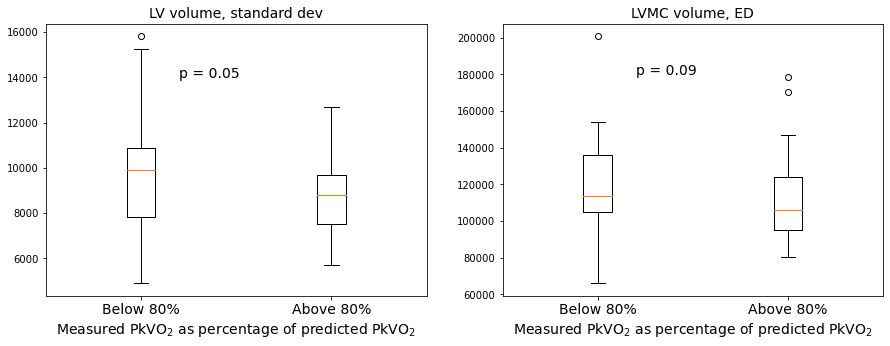

In [44]:
box_plot_func('LV volume, standard dev', 'LVMC volume, ED',  vol_df, 'lv_std', 'lvmc_vol_ed', 14000, 180000)

#### Correlation analysis

In [45]:
pids = vol_df.patient_id.values
pkvo2_vals = []
petco2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    petco2_vals.append(cpet_record['PetCO2.2'].values[0])    

In [46]:
vol_df['pkvo2'] = pkvo2_vals
vol_df['petco2'] = petco2_vals

In [47]:
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(vol_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), "{:.2e}".format(pearson_val[1])))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: 
(feature name, R^2, p-value)

('lvmc_vol_min', 0.279, '6.75e-05')
('lv_vol_es', 0.263, '1.20e-04')
('lvmc_vol_ed', 0.255, '1.57e-04')
('lv_vol_ed', 0.234, '3.23e-04')
('lvmc_vol_es', 0.224, '4.60e-04')
('lvmc_vol_max', 0.211, '6.93e-04')
('lv_snr', 0.131, '9.13e-03')
('ejection_fraction', 0.107, '1.93e-02')


In [48]:
important_features.append('lvmc_vol_min')
important_features

['lvmc_vol_ed', 'lv_std', 'lvmc_vol_min']

In [49]:
null_petco2_pids = vol_df[vol_df['petco2'].isna()].patient_id.values
print('patient ids with missing Pet CO2 \n', null_petco2_pids)

patient ids with missing Pet CO2 
 ['135']


In [50]:
response = vol_df[~vol_df['patient_id'].isin(null_petco2_pids)]['petco2']
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(vol_df[~vol_df['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: 
(feature name, R^2, p-value)

('lv_vol_ed', 0.321, 1.8e-05)
('stroke_volume', 0.238, 0.000328)
('lv_vol_es', 0.184, 0.001898)
('lvmc_vol_max', 0.151, 0.005288)
('lvmc_vol_es', 0.146, 0.006191)
('lvmc_vol_min', 0.141, 0.007303)
('lvmc_vol_ed', 0.13, 0.010188)


In [51]:
important_features.extend(['lv_vol_ed', 'stroke_volume', 'lvmc_vol_max'])

### Pyradiomics 3d features

In [52]:
pyrads_3d_df = pd.read_csv('pyrads_3d.csv')
pyrads_3d_df.drop(columns='Unnamed: 0',inplace=True);
pyrads_3d_df.tail()

,min_original_shape_Elongation,min_original_shape_Flatness,min_original_shape_LeastAxisLength,min_original_shape_MajorAxisLength,min_original_shape_Maximum2DDiameterColumn,min_original_shape_Maximum2DDiameterRow,min_original_shape_Maximum2DDiameterSlice,min_original_shape_Maximum3DDiameter,min_original_shape_MeshVolume,min_original_shape_MinorAxisLength,...,ed_val_original_shape_Maximum2DDiameterRow,ed_val_original_shape_Maximum2DDiameterSlice,ed_val_original_shape_Maximum3DDiameter,ed_val_original_shape_MeshVolume,ed_val_original_shape_MinorAxisLength,ed_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea,ed_val_original_shape_SurfaceVolumeRatio,ed_val_original_shape_VoxelVolume,patient_id
52,0.506334,0.495642,35.047752,63.474620,68.597103,69.779228,42.085107,71.850213,56400.609375,36.507579,...,95.353372,62.476496,97.227906,155348.453125,51.860836,0.759987,18388.619097,0.118370,156831.9375,181
53,0.433687,0.405421,36.375446,73.163911,83.735073,81.412530,48.904243,88.452318,80641.195312,39.807814,...,98.924529,65.689254,103.712343,159982.226562,57.096478,0.781472,18236.940063,0.113994,161434.6875,121
54,0.442772,0.411883,39.077575,75.216261,82.547808,86.256884,51.379106,86.778454,76836.593750,42.008184,...,94.252652,59.375000,95.707644,115302.835938,49.954742,0.753739,15199.286437,0.131821,116693.2500,119
55,0.534887,0.501297,38.785281,71.689403,78.340702,80.331442,51.269204,81.585557,76698.398438,41.384085,...,95.353372,68.009650,96.412282,174357.359375,56.197915,0.750116,20120.974777,0.115401,175919.8125,126
56,0.352793,0.329828,26.018235,77.215350,72.351680,81.412530,36.252802,81.723715,26059.687500,27.829834,...,98.894199,58.223841,101.761517,107138.031250,47.723800,0.663028,16453.116964,0.153569,108773.8125,113B


In [65]:
pyrads_3d_df.describe().T

,count,mean,std,min,25%,50%,75%,max
min_original_shape_Elongation,57.0,0.484974,0.063580,0.337322,0.449481,0.493708,0.534887,0.599829
min_original_shape_Flatness,57.0,0.433950,0.056031,0.315769,0.399846,0.440029,0.485829,0.533986
min_original_shape_LeastAxisLength,57.0,34.939201,5.283151,23.784889,31.718557,34.641259,38.210702,49.817307
min_original_shape_MajorAxisLength,57.0,74.823154,10.610705,51.937018,66.514456,73.629509,82.730094,101.394964
min_original_shape_Maximum2DDiameterColumn,57.0,81.483519,10.445174,62.936476,75.815978,79.306762,88.131216,110.193083
...,...,...,...,...,...,...,...,...
ed_val_original_shape_MinorAxisLength,57.0,52.770056,4.563227,42.437262,49.954742,52.213807,55.639177,63.041983
ed_val_original_shape_Sphericity,57.0,0.743139,0.042845,0.624884,0.723229,0.753739,0.773154,0.806397
ed_val_original_shape_SurfaceArea,57.0,18330.127847,3231.018300,12633.063217,16270.985150,17507.641426,20510.673146,27561.485427
ed_val_original_shape_SurfaceVolumeRatio,57.0,0.124394,0.012305,0.105672,0.115210,0.122641,0.129681,0.159521


In [30]:
low_lv_ef = np.append(low_lv_ef,'188')

In [53]:
pyrads_3d_df = pyrads_3d_df[~pyrads_3d_df['patient_id'].isin(low_lv_ef)]
pyrads_3d_df.shape

(51, 113)

In [54]:
pyrads_3d_columns = pyrads_3d_df.columns
numerical_columns = pyrads_3d_columns.drop(['patient_id']).values

In [55]:
outlier_features = outlier_func(pyrads_3d_df, numerical_columns, 4)
outlier_features

['std_dev_original_shape_Maximum2DDiameterSlice',
 'snr_original_shape_MajorAxisLength',
 'snr_original_shape_Maximum2DDiameterRow',
 'snr_original_shape_Maximum2DDiameterSlice',
 'snr_original_shape_Sphericity']

In [56]:
pyrads_3d_df_scaled = pyrads_3d_df.copy(deep=True)
pyrads_3d_df_scaled[numerical_columns] = scaler.fit_transform(pyrads_3d_df[numerical_columns])

<AxesSubplot:>

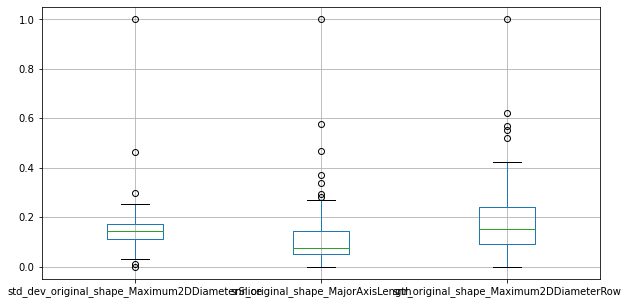

In [45]:
pyrads_3d_df_scaled.boxplot(column = outlier_features[0:3], figsize = (10,5))

<AxesSubplot:>

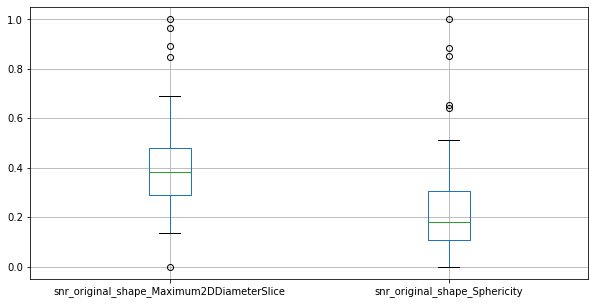

In [46]:
pyrads_3d_df_scaled.boxplot(column = outlier_features[3:], figsize = (10,5))

In [59]:
u_test_pyrads_3d_features, _, _ = u_test_func(pyrads_3d_df, numerical_columns)

In [60]:
significant_feat = [ent for ent in u_test_pyrads_3d_features if ent[1] < 0.05]
print('significant features: (feature name, p-value)')
[print(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])];

significant features: (feature name, p-value)
median_original_shape_Sphericity 0.023
mean_original_shape_Sphericity 0.03
max_original_shape_SurfaceArea 0.039
es_val_original_shape_Sphericity 0.041
mean_original_shape_SurfaceArea 0.044
ed_val_original_shape_SurfaceArea 0.044
min_original_shape_Sphericity 0.05


In [50]:
important_features.extend([feat[0] for feat in significant_feat])
important_features

['lvmc_vol_ed',
 'lv_std',
 'lvmc_vol_min',
 'lv_vol_ed',
 'stroke_volume',
 'lvmc_vol_max',
 'min_original_shape_Sphericity',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_Sphericity',
 'mean_original_shape_SurfaceArea',
 'median_original_shape_Sphericity',
 'es_val_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea']

In [51]:
pids = pyrads_3d_df.patient_id.values
pkvo2_vals = []
petco2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    petco2_vals.append(cpet_record['PetCO2.2'].values[0])  
    
pyrads_3d_df['pkvo2'] = pkvo2_vals
pyrads_3d_df['petco2'] = petco2_vals

In [52]:
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(pyrads_3d_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

('min_original_shape_VoxelVolume', 0.263, 0.00012)
('es_val_original_shape_VoxelVolume', 0.263, 0.00012)
('min_original_shape_MeshVolume', 0.262, 0.000125)
('es_val_original_shape_MeshVolume', 0.262, 0.000125)
('mean_original_shape_VoxelVolume', 0.252, 0.000176)
('mean_original_shape_MeshVolume', 0.251, 0.000182)
('median_original_shape_MeshVolume', 0.25, 0.000189)
('median_original_shape_VoxelVolume', 0.25, 0.000188)
('median_original_shape_SurfaceVolumeRatio', 0.246, 0.000217)
('mean_original_shape_SurfaceVolumeRatio', 0.244, 0.000233)
('max_original_shape_VoxelVolume', 0.234, 0.000323)
('ed_val_original_shape_VoxelVolume', 0.234, 0.000323)
('min_original_shape_SurfaceArea', 0.232, 0.000348)
('max_original_shape_MeshVolume', 0.232, 0.000341)
('ed_val_original_shape_MeshVolume', 0.232, 0.000341)
('median_original_shape_LeastAxisLength', 0.229, 0.000385)
('es_val_original_shape_SurfaceArea', 0.229, 0.000386)
('max_original_shape_SurfaceVolumeRatio', 0.228, 0.000398)
('es_val_original_s

In [53]:
important_features.extend(['min_original_shape_VoxelVolume', 'mean_original_shape_LeastAxisLength', \
        'median_original_shape_SurfaceVolumeRatio', 'median_original_shape_MinorAxisLength',\
        'ed_val_original_shape_Maximum3DDiameter', 'max_original_shape_Maximum2DDiameterColumn'])

In [54]:
response = pyrads_3d_df[~pyrads_3d_df['patient_id'].isin(null_petco2_pids)]['petco2']
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(pyrads_3d_df[~pyrads_3d_df['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.2];

significant features: 
(feature name, R^2, p-value)

('max_original_shape_Maximum2DDiameterRow', 0.409, 1e-06)
('ed_val_original_shape_Maximum2DDiameterRow', 0.399, 1e-06)
('ed_val_original_shape_Maximum3DDiameter', 0.382, 2e-06)
('mean_original_shape_Maximum2DDiameterRow', 0.359, 4e-06)
('mean_original_shape_Maximum3DDiameter', 0.337, 1e-05)
('median_original_shape_Maximum2DDiameterRow', 0.327, 1.4e-05)
('max_original_shape_MeshVolume', 0.321, 1.8e-05)
('max_original_shape_VoxelVolume', 0.321, 1.8e-05)
('ed_val_original_shape_MeshVolume', 0.321, 1.8e-05)
('ed_val_original_shape_VoxelVolume', 0.321, 1.8e-05)
('max_original_shape_Maximum2DDiameterColumn', 0.314, 2.3e-05)
('median_original_shape_Maximum3DDiameter', 0.311, 2.6e-05)
('mean_original_shape_MajorAxisLength', 0.31, 2.7e-05)
('ed_val_original_shape_Maximum2DDiameterColumn', 0.294, 4.7e-05)
('ed_val_original_shape_MajorAxisLength', 0.289, 5.7e-05)
('mean_original_shape_Maximum2DDiameterColumn', 0.288, 5.8e-05)
('max_original_sha

In [55]:
important_features.extend(['max_original_shape_Maximum2DDiameterRow', 'mean_original_shape_Maximum3DDiameter',\
            'max_original_shape_MeshVolume', 'max_original_shape_Maximum2DDiameterColumn',\
            'ed_val_original_shape_MajorAxisLength'])

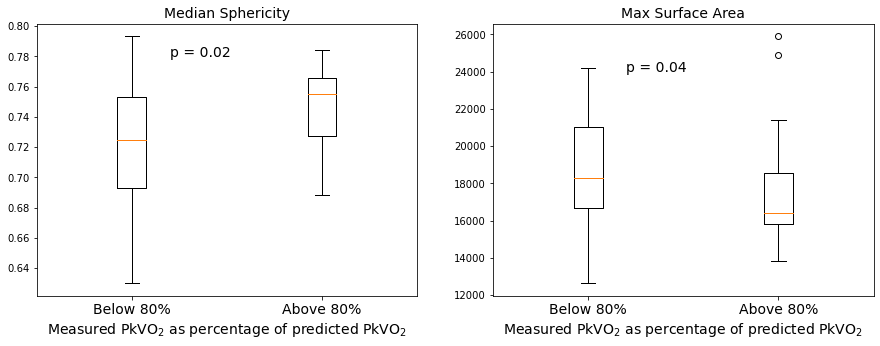

In [61]:
box_plot_func('Median Sphericity', 'Max Surface Area',  pyrads_3d_df, \
        'median_original_shape_Sphericity', 'max_original_shape_SurfaceArea', 0.78, 24000)

### 3D Fractal features

In [62]:
fractals_3d_df = pd.read_csv('fractals_3d.csv')
fractals_3d_df.drop(columns='Unnamed: 0',inplace=True);
fractals_3d_df.head()

,lv_max_slope,lv_max_inc,lv_min_slope,lv_min_inc,lv_mean_slope,lv_mean_inc,lv_median_slope,lv_median_inc,lv_ed_slope,lv_ed_inc,...,lvmc_min_inc,lvmc_mean_slope,lvmc_mean_inc,lvmc_median_slope,lvmc_median_inc,lvmc_ed_slope,lvmc_ed_inc,lvmc_es_slope,lvmc_es_inc,patient_id
0,2.479988,7.346413,1.963456,6.064861,2.275728,6.760670,2.342396,6.886595,2.458897,7.346413,...,6.965695,2.273299,7.181236,2.275288,7.238113,2.239110,7.315423,2.271066,7.039687,153
1,2.413301,7.404196,2.186582,6.476394,2.322058,7.036596,2.344578,7.186857,2.413301,7.404196,...,7.484620,2.338499,7.544748,2.324051,7.543040,2.324051,7.531694,2.377132,7.528839,154
2,2.366648,7.101825,2.074160,6.248441,2.213915,6.648769,2.183091,6.642925,2.366648,7.101825,...,6.980443,2.232655,7.121495,2.242075,7.118396,2.310661,7.293535,2.249362,7.070714,162
3,2.558215,8.257276,2.322868,7.386463,2.478927,7.865453,2.493921,7.980278,2.558215,8.257276,...,7.982848,2.421854,8.162983,2.426577,8.204169,2.409906,8.211593,2.420886,8.054498,191
4,2.557690,7.792839,2.048207,6.216915,2.405354,7.158140,2.426958,7.246218,2.555350,7.792839,...,7.537170,2.417745,7.761672,2.432243,7.819010,2.437533,7.942699,2.347765,7.537170,109


In [63]:
fractals_3d_df = fractals_3d_df[~fractals_3d_df['patient_id'].isin(low_lv_ef)]
fractals_3d_df.shape

(51, 25)

In [64]:
fractals_3d_columns = fractals_3d_df.columns
numerical_columns = fractals_3d_columns.drop(['patient_id']).values

In [65]:
outlier_features = outlier_func(fractals_3d_df, numerical_columns, 4)
outlier_features

['lv_ed_inc', 'lvmc_es_inc']

In [66]:
fractals_3d_df_scaled = fractals_3d_df.copy(deep=True)
fractals_3d_df_scaled[numerical_columns] = scaler.fit_transform(fractals_3d_df[numerical_columns])

<AxesSubplot:>

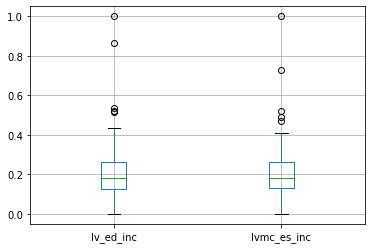

In [61]:
fractals_3d_df_scaled.boxplot(column = list(outlier_features))

#### U test with 3d fractal features

In [67]:
u_test_fractals_3d_features, _, _ = u_test_func(fractals_3d_df, numerical_columns)

In [68]:
significant_feat = [ent for ent in u_test_fractals_3d_features if ent[1] < 0.08]
print('significant features: (feature name, p-value)')
[print(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])];

significant features: (feature name, p-value)
lv_min_slope 0.071
lvmc_min_slope 0.071


In [64]:
important_features.extend([feat[0] for feat in significant_feat])
important_features

['lvmc_vol_ed',
 'lv_std',
 'lvmc_vol_min',
 'lv_vol_ed',
 'stroke_volume',
 'lvmc_vol_max',
 'min_original_shape_Sphericity',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_Sphericity',
 'mean_original_shape_SurfaceArea',
 'median_original_shape_Sphericity',
 'es_val_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'min_original_shape_VoxelVolume',
 'mean_original_shape_LeastAxisLength',
 'median_original_shape_SurfaceVolumeRatio',
 'median_original_shape_MinorAxisLength',
 'ed_val_original_shape_Maximum3DDiameter',
 'max_original_shape_Maximum2DDiameterColumn',
 'max_original_shape_Maximum2DDiameterRow',
 'mean_original_shape_Maximum3DDiameter',
 'max_original_shape_MeshVolume',
 'max_original_shape_Maximum2DDiameterColumn',
 'ed_val_original_shape_MajorAxisLength',
 'lv_min_slope',
 'lvmc_min_slope']

In [66]:
pids = fractals_3d_df.patient_id.values
pkvo2_vals = []
petco2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    petco2_vals.append(cpet_record['PetCO2.2'].values[0])    
    
fractals_3d_df['pkvo2'] = pkvo2_vals
fractals_3d_df['petco2'] = petco2_vals

In [67]:
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(fractals_3d_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],3)))
print('significant features: (feature name, p-value)')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: (feature name, p-value)


In [68]:
response = fractals_3d_df[~fractals_3d_df['patient_id'].isin(null_petco2_pids)]['petco2']
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(fractals_3d_df[~fractals_3d_df['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.2];

significant features: 
(feature name, R^2, p-value)



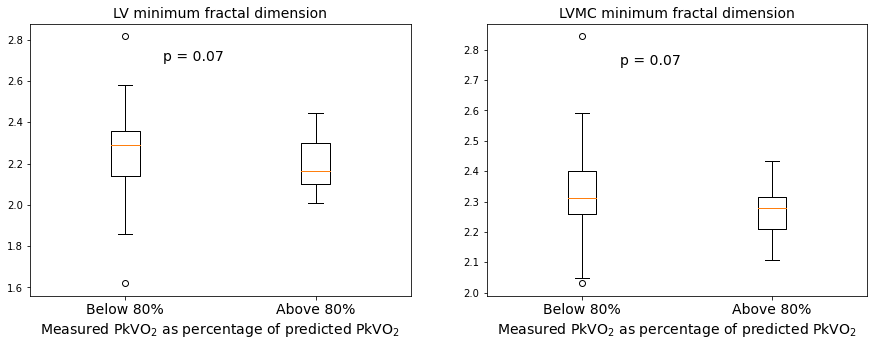

In [69]:
box_plot_func('LV minimum fractal dimension', 'LVMC minimum fractal dimension',  fractals_3d_df, \
        'lv_min_slope', 'lvmc_min_slope', 2.7, 2.75)

## Multivariate Analysis

In [69]:
important_features = list(set(important_features))
important_features

['lvmc_vol_max',
 'mean_original_shape_LeastAxisLength',
 'max_original_shape_MeshVolume',
 'ed_val_original_shape_SurfaceArea',
 'mean_original_shape_SurfaceArea',
 'max_original_shape_SurfaceArea',
 'max_original_shape_Maximum2DDiameterRow',
 'lv_std',
 'min_original_shape_VoxelVolume',
 'mean_original_shape_Sphericity',
 'min_original_shape_Sphericity',
 'lvmc_min_slope',
 'max_original_shape_Maximum2DDiameterColumn',
 'lvmc_vol_min',
 'median_original_shape_SurfaceVolumeRatio',
 'lvmc_vol_ed',
 'mean_original_shape_Maximum3DDiameter',
 'lv_min_slope',
 'median_original_shape_Sphericity',
 'es_val_original_shape_Sphericity',
 'ed_val_original_shape_MajorAxisLength',
 'ed_val_original_shape_Maximum3DDiameter',
 'median_original_shape_MinorAxisLength',
 'stroke_volume',
 'lv_vol_ed']

In [70]:
pyrads_df = pd.read_csv('pyrads_3d.csv')
pyrads_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(pyrads_df.columns.values) & set(important_features))
pyrads_df_imp = pyrads_df[['patient_id']+common_features]
pyrads_df_imp.head()

,patient_id,mean_original_shape_Sphericity,max_original_shape_MeshVolume,mean_original_shape_LeastAxisLength,min_original_shape_Sphericity,max_original_shape_Maximum2DDiameterColumn,ed_val_original_shape_SurfaceArea,ed_val_original_shape_Maximum3DDiameter,mean_original_shape_SurfaceArea,median_original_shape_MinorAxisLength,max_original_shape_SurfaceArea,max_original_shape_Maximum2DDiameterRow,mean_original_shape_Maximum3DDiameter,median_original_shape_SurfaceVolumeRatio,median_original_shape_Sphericity,es_val_original_shape_Sphericity,ed_val_original_shape_MajorAxisLength,min_original_shape_VoxelVolume
0,153,0.748110,104904.343750,35.280432,0.723153,89.494501,14611.078910,93.411054,10936.135230,39.435757,14611.078910,92.195445,86.670798,0.153127,0.748158,0.723153,79.810201,39664.875000
1,154,0.760355,128671.117188,40.655252,0.732408,91.242209,15848.950767,92.011718,12814.214611,47.963631,15848.950767,89.494501,84.667249,0.134614,0.767928,0.734934,80.581778,46027.500000
2,162,0.718751,80063.031250,33.123916,0.677365,82.547808,12633.063217,85.237261,9945.222198,37.743858,12633.063217,81.412530,82.550290,0.174758,0.712053,0.704503,76.028604,38920.312500
3,191,0.683184,150684.231441,41.059555,0.646605,108.751222,19440.135711,120.465067,15551.672444,43.245158,19440.135711,120.244185,112.610973,0.145488,0.685203,0.646605,102.319481,58658.037807
4,109,0.720003,151871.007812,38.089976,0.664806,100.842777,18885.775024,102.946360,13585.015101,44.172514,18885.775024,101.595091,88.857282,0.149964,0.728897,0.737380,89.894066,42440.062500


In [71]:
vol_df = pd.read_csv('vol.csv')
vol_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(vol_df.columns.values) & set(important_features))
vol_df_imp = vol_df[['patient_id']+common_features]
vol_df_imp.head()

,patient_id,lvmc_vol_max,lvmc_vol_min,lvmc_vol_ed,lv_std,stroke_volume,lv_vol_ed
0,153,85489.312500,73305.562500,85015.500000,7965.467931,66604.500000,106269.375000
1,154,109586.062500,94762.500000,103155.750000,9425.673423,84000.187500,130027.687500
2,162,75674.625000,67416.750000,71071.875000,4889.557224,42507.750000,81428.062500
3,191,114963.373894,103040.360091,103040.360091,6097.426044,93230.790206,151888.828014
4,109,135239.625000,111413.625000,126507.937500,15817.902632,111007.500000,153447.562500


In [72]:
important_features_df = pd.merge(pyrads_df_imp, vol_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,mean_original_shape_Sphericity,max_original_shape_MeshVolume,mean_original_shape_LeastAxisLength,min_original_shape_Sphericity,max_original_shape_Maximum2DDiameterColumn,ed_val_original_shape_SurfaceArea,ed_val_original_shape_Maximum3DDiameter,mean_original_shape_SurfaceArea,median_original_shape_MinorAxisLength,...,median_original_shape_Sphericity,es_val_original_shape_Sphericity,ed_val_original_shape_MajorAxisLength,min_original_shape_VoxelVolume,lvmc_vol_max,lvmc_vol_min,lvmc_vol_ed,lv_std,stroke_volume,lv_vol_ed
0,153,0.748110,104904.343750,35.280432,0.723153,89.494501,14611.078910,93.411054,10936.135230,39.435757,...,0.748158,0.723153,79.810201,39664.875000,85489.312500,73305.562500,85015.500000,7965.467931,66604.500000,106269.375000
1,154,0.760355,128671.117188,40.655252,0.732408,91.242209,15848.950767,92.011718,12814.214611,47.963631,...,0.767928,0.734934,80.581778,46027.500000,109586.062500,94762.500000,103155.750000,9425.673423,84000.187500,130027.687500
2,162,0.718751,80063.031250,33.123916,0.677365,82.547808,12633.063217,85.237261,9945.222198,37.743858,...,0.712053,0.704503,76.028604,38920.312500,75674.625000,67416.750000,71071.875000,4889.557224,42507.750000,81428.062500
3,191,0.683184,150684.231441,41.059555,0.646605,108.751222,19440.135711,120.465067,15551.672444,43.245158,...,0.685203,0.646605,102.319481,58658.037807,114963.373894,103040.360091,103040.360091,6097.426044,93230.790206,151888.828014
4,109,0.720003,151871.007812,38.089976,0.664806,100.842777,18885.775024,102.946360,13585.015101,44.172514,...,0.728897,0.737380,89.894066,42440.062500,135239.625000,111413.625000,126507.937500,15817.902632,111007.500000,153447.562500


In [73]:
fractals_3d_df = pd.read_csv('fractals_3d.csv')
fractals_3d_df.drop(columns=['Unnamed: 0'],inplace=True)
common_features = list(set(fractals_3d_df.columns.values) & set(important_features))
fractals_3d_df_imp = fractals_3d_df[['patient_id']+common_features]
fractals_3d_df_imp.head()

,patient_id,lv_min_slope,lvmc_min_slope
0,153,1.963456,2.224151
1,154,2.186582,2.288623
2,162,2.074160,2.137551
3,191,2.322868,2.354578
4,109,2.048207,2.335396


In [74]:
important_features_df = pd.merge(important_features_df, fractals_3d_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,mean_original_shape_Sphericity,max_original_shape_MeshVolume,mean_original_shape_LeastAxisLength,min_original_shape_Sphericity,max_original_shape_Maximum2DDiameterColumn,ed_val_original_shape_SurfaceArea,ed_val_original_shape_Maximum3DDiameter,mean_original_shape_SurfaceArea,median_original_shape_MinorAxisLength,...,ed_val_original_shape_MajorAxisLength,min_original_shape_VoxelVolume,lvmc_vol_max,lvmc_vol_min,lvmc_vol_ed,lv_std,stroke_volume,lv_vol_ed,lv_min_slope,lvmc_min_slope
0,153,0.748110,104904.343750,35.280432,0.723153,89.494501,14611.078910,93.411054,10936.135230,39.435757,...,79.810201,39664.875000,85489.312500,73305.562500,85015.500000,7965.467931,66604.500000,106269.375000,1.963456,2.224151
1,154,0.760355,128671.117188,40.655252,0.732408,91.242209,15848.950767,92.011718,12814.214611,47.963631,...,80.581778,46027.500000,109586.062500,94762.500000,103155.750000,9425.673423,84000.187500,130027.687500,2.186582,2.288623
2,162,0.718751,80063.031250,33.123916,0.677365,82.547808,12633.063217,85.237261,9945.222198,37.743858,...,76.028604,38920.312500,75674.625000,67416.750000,71071.875000,4889.557224,42507.750000,81428.062500,2.074160,2.137551
3,191,0.683184,150684.231441,41.059555,0.646605,108.751222,19440.135711,120.465067,15551.672444,43.245158,...,102.319481,58658.037807,114963.373894,103040.360091,103040.360091,6097.426044,93230.790206,151888.828014,2.322868,2.354578
4,109,0.720003,151871.007812,38.089976,0.664806,100.842777,18885.775024,102.946360,13585.015101,44.172514,...,89.894066,42440.062500,135239.625000,111413.625000,126507.937500,15817.902632,111007.500000,153447.562500,2.048207,2.335396


In [75]:
important_features_df = important_features_df[~important_features_df['patient_id'].isin(low_lv_ef)].copy(deep=True)
important_features_df.shape

(51, 26)

In [76]:
important_features_columns = important_features_df.columns
important_features_columns

Index(['patient_id', 'mean_original_shape_Sphericity',
       'max_original_shape_MeshVolume', 'mean_original_shape_LeastAxisLength',
       'min_original_shape_Sphericity',
       'max_original_shape_Maximum2DDiameterColumn',
       'ed_val_original_shape_SurfaceArea',
       'ed_val_original_shape_Maximum3DDiameter',
       'mean_original_shape_SurfaceArea',
       'median_original_shape_MinorAxisLength',
       'max_original_shape_SurfaceArea',
       'max_original_shape_Maximum2DDiameterRow',
       'mean_original_shape_Maximum3DDiameter',
       'median_original_shape_SurfaceVolumeRatio',
       'median_original_shape_Sphericity', 'es_val_original_shape_Sphericity',
       'ed_val_original_shape_MajorAxisLength',
       'min_original_shape_VoxelVolume', 'lvmc_vol_max', 'lvmc_vol_min',
       'lvmc_vol_ed', 'lv_std', 'stroke_volume', 'lv_vol_ed', 'lv_min_slope',
       'lvmc_min_slope'],
      dtype='object')

In [77]:
numerical_columns = important_features_columns.drop('patient_id').values
important_features_df_scaled = important_features_df.copy(deep=True)
important_features_df_scaled[numerical_columns] = scaler.fit_transform(important_features_df[numerical_columns])

<AxesSubplot:>

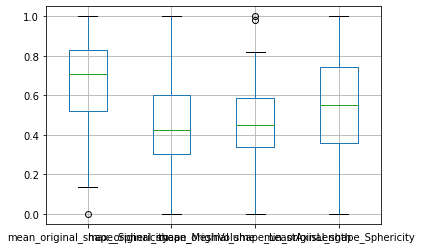

In [78]:
important_features_df_scaled.boxplot(column = list(numerical_columns)[0:4])

<AxesSubplot:>

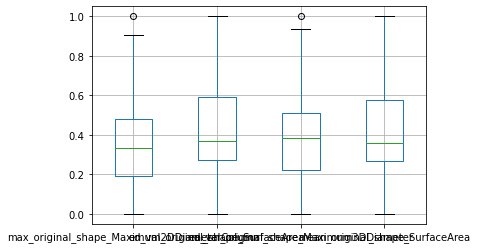

In [79]:
important_features_df_scaled.boxplot(column = list(numerical_columns)[4:8])

In [81]:
vo2_max = []
num_rows = important_features_df.shape[0]
for n in range(num_rows):
    pid = important_features_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    vo2_max.append((pid,cpet_record['VO2 (MAX):'].values[0],\
                               cpet_record['dyspnea'].values[0],\
                          cpet_record['PetCO2.2'].values[0]))

In [82]:
important_features_df['pkvo2'] = [ent[1] for ent in vo2_max]
important_features_df['dyspnea'] = [ent[2] for ent in vo2_max]
important_features_df['petco2'] = [ent[3] for ent in vo2_max]

In [83]:
important_features_df.head()

,patient_id,mean_original_shape_Sphericity,max_original_shape_MeshVolume,mean_original_shape_LeastAxisLength,min_original_shape_Sphericity,max_original_shape_Maximum2DDiameterColumn,ed_val_original_shape_SurfaceArea,ed_val_original_shape_Maximum3DDiameter,mean_original_shape_SurfaceArea,median_original_shape_MinorAxisLength,...,lvmc_vol_min,lvmc_vol_ed,lv_std,stroke_volume,lv_vol_ed,lv_min_slope,lvmc_min_slope,pkvo2,dyspnea,petco2
0,153,0.748110,104904.343750,35.280432,0.723153,89.494501,14611.078910,93.411054,10936.135230,39.435757,...,73305.562500,85015.500000,7965.467931,66604.500000,106269.375000,1.963456,2.224151,1.14,1.0,22.0
1,154,0.760355,128671.117188,40.655252,0.732408,91.242209,15848.950767,92.011718,12814.214611,47.963631,...,94762.500000,103155.750000,9425.673423,84000.187500,130027.687500,2.186582,2.288623,1.87,0.0,30.0
2,162,0.718751,80063.031250,33.123916,0.677365,82.547808,12633.063217,85.237261,9945.222198,37.743858,...,67416.750000,71071.875000,4889.557224,42507.750000,81428.062500,2.074160,2.137551,0.59,1.0,14.0
3,191,0.683184,150684.231441,41.059555,0.646605,108.751222,19440.135711,120.465067,15551.672444,43.245158,...,103040.360091,103040.360091,6097.426044,93230.790206,151888.828014,2.322868,2.354578,1.67,1.0,36.0
4,109,0.720003,151871.007812,38.089976,0.664806,100.842777,18885.775024,102.946360,13585.015101,44.172514,...,111413.625000,126507.937500,15817.902632,111007.500000,153447.562500,2.048207,2.335396,1.23,1.0,27.0


In [84]:
response = important_features_df['pkvo2'] 
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(important_features_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: 
(feature name, R^2, p-value)

('lvmc_vol_min', 0.279, 6.8e-05)
('min_original_shape_VoxelVolume', 0.263, 0.00012)
('lvmc_vol_ed', 0.255, 0.000157)
('median_original_shape_SurfaceVolumeRatio', 0.246, 0.000217)
('lv_vol_ed', 0.234, 0.000323)
('max_original_shape_MeshVolume', 0.232, 0.000341)
('mean_original_shape_LeastAxisLength', 0.218, 0.000555)
('median_original_shape_MinorAxisLength', 0.218, 0.000558)
('lvmc_vol_max', 0.211, 0.000693)
('mean_original_shape_SurfaceArea', 0.201, 0.000962)
('ed_val_original_shape_SurfaceArea', 0.187, 0.001529)
('ed_val_original_shape_Maximum3DDiameter', 0.185, 0.001642)
('max_original_shape_Maximum2DDiameterColumn', 0.183, 0.001734)
('max_original_shape_SurfaceArea', 0.178, 0.002041)
('mean_original_shape_Maximum3DDiameter', 0.158, 0.003931)
('max_original_shape_Maximum2DDiameterRow', 0.14, 0.006786)
('ed_val_original_shape_MajorAxisLength', 0.105, 0.020087)


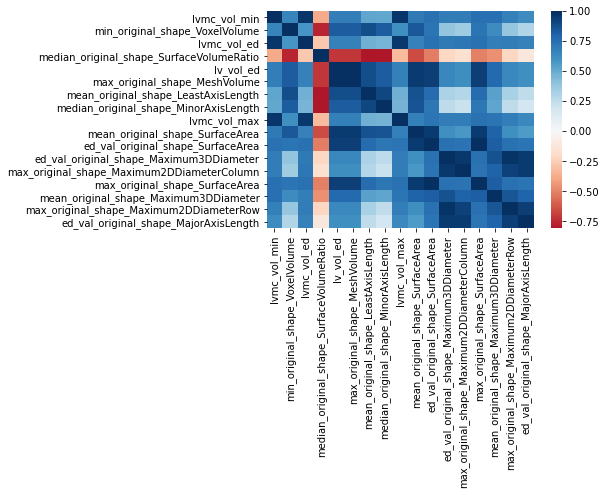

In [85]:
sns.heatmap(important_features_df[[ent[0] for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) \
                                   if ent[1] > 0.1]].corr(),cmap = 'RdBu', center = 0.0);

In [86]:
important_features_subset = ['lvmc_vol_min', 'median_original_shape_SurfaceVolumeRatio']
vif_values = [vif(important_features_df_scaled[important_features_subset].values, i) for i in range(len(important_features_subset))]
vif_feat_vals = {important_features_subset[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

median_original_shape_SurfaceVolumeRatio 1.6
lvmc_vol_min 1.6


In [87]:
multivariate_x = important_features_df_scaled[important_features_subset]
multivariate_y = important_features_df[['pkvo2']]

In [88]:
reg = LinearRegression().fit(multivariate_x, multivariate_y)
print('R^2 score =',round(reg.score(multivariate_x, multivariate_y),3))

R^2 score = 0.383


In [89]:
data = pd.DataFrame({'x0': multivariate_x[important_features_subset[0]], \
                     'x1': multivariate_x[important_features_subset[1]], \
                     'y': multivariate_y.pkvo2.values})

In [90]:
model = ols("y ~ x0 + x1 ", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     14.92
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           9.15e-06
Time:                        10:24:32   Log-Likelihood:                -33.424
No. Observations:                  51   AIC:                             72.85
Df Residuals:                      48   BIC:                             78.64
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7620      0.204      8.650      0.0

In [91]:
response = important_features_df[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)]['petco2'] 
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(important_features_df[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
print('significant features: \n(feature name, R^2, p-value)\n')
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

significant features: 
(feature name, R^2, p-value)

('max_original_shape_Maximum2DDiameterRow', 0.409, 1e-06)
('ed_val_original_shape_Maximum3DDiameter', 0.382, 2e-06)
('mean_original_shape_Maximum3DDiameter', 0.337, 1e-05)
('max_original_shape_MeshVolume', 0.321, 1.8e-05)
('lv_vol_ed', 0.321, 1.8e-05)
('max_original_shape_Maximum2DDiameterColumn', 0.314, 2.3e-05)
('ed_val_original_shape_MajorAxisLength', 0.289, 5.7e-05)
('ed_val_original_shape_SurfaceArea', 0.277, 8.7e-05)
('max_original_shape_SurfaceArea', 0.277, 8.6e-05)
('mean_original_shape_SurfaceArea', 0.242, 0.000287)
('stroke_volume', 0.238, 0.000328)
('mean_original_shape_LeastAxisLength', 0.201, 0.001103)
('min_original_shape_VoxelVolume', 0.184, 0.001898)
('median_original_shape_SurfaceVolumeRatio', 0.18, 0.002129)
('lvmc_vol_max', 0.151, 0.005288)
('median_original_shape_MinorAxisLength', 0.15, 0.005466)
('lvmc_vol_min', 0.141, 0.007303)
('lvmc_vol_ed', 0.13, 0.010188)
('lv_min_slope', 0.112, 0.017418)


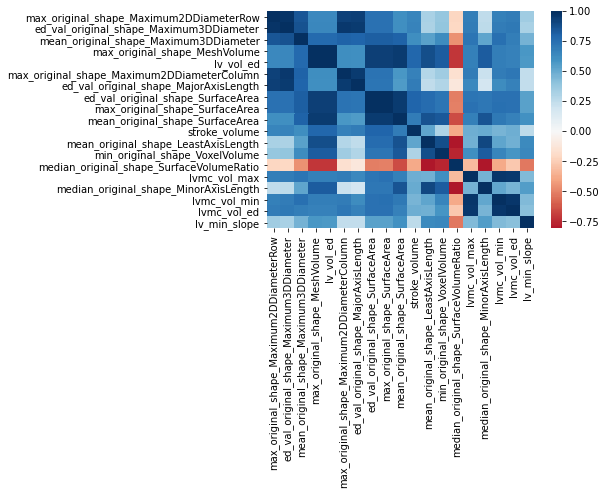

In [92]:
sns.heatmap(important_features_df[[ent[0] for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=True) \
                                   if ent[1] > 0.1]].corr(),cmap = 'RdBu', center = 0.0);

In [93]:
important_features_subset = ['max_original_shape_Maximum2DDiameterRow', 'median_original_shape_SurfaceVolumeRatio']
vif_values = [vif(important_features_df_scaled[important_features_subset].values, i) for i in range(len(important_features_subset))]
vif_feat_vals = {important_features_subset[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

max_original_shape_Maximum2DDiameterRow 1.839
median_original_shape_SurfaceVolumeRatio 1.839


In [94]:
multivariate_x = important_features_df_scaled[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][important_features_subset]
multivariate_y = important_features_df[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][['petco2']]

In [95]:
reg = LinearRegression().fit(multivariate_x, multivariate_y)
print('R^2 score =',round(reg.score(multivariate_x, multivariate_y),3))

R^2 score = 0.498


In [96]:
data = pd.DataFrame({'x0': multivariate_x[important_features_subset[0]], \
                     'x1': multivariate_x[important_features_subset[1]], \
                     #'x2': multivariate_x[important_features_subset[2]], \
                     #'x3': multivariate_x[important_features_subset[3]], \
                     'y': multivariate_y.petco2.values})

In [97]:
model = ols("y ~ x0 + x1", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     23.27
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           9.45e-08
Time:                        10:25:07   Log-Likelihood:                -142.85
No. Observations:                  50   AIC:                             291.7
Df Residuals:                      47   BIC:                             297.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.2358      1.740     13.927      0.0

### Hierarchical clustering

In [98]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from matplotlib.pyplot import figure

In [99]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_font_size = 12, leaf_rotation = 0)
    return linkage_matrix

In [200]:
important_features_subset_shortlist =['lvmc_vol_min', 'median_original_shape_SurfaceVolumeRatio',\
            'max_original_shape_Maximum2DDiameterRow', \
            'lvmc_vol_ed', 'lv_std',\
            'min_original_shape_Sphericity',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_Sphericity',
 'mean_original_shape_SurfaceArea',
 'median_original_shape_Sphericity',
 'es_val_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'lv_min_slope',
 'lvmc_min_slope']

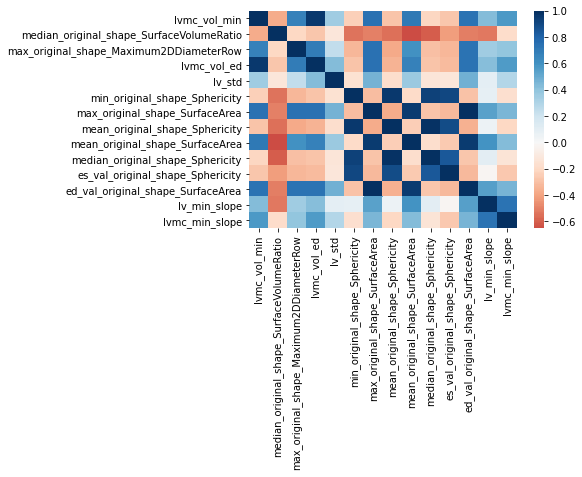

In [201]:
sns.heatmap(important_features_df[important_features_subset_shortlist].corr(),cmap = 'RdBu', center = 0.0);

In [204]:
important_features_subset_hcluster = ['lv_std', 'median_original_shape_Sphericity',\
 'median_original_shape_SurfaceVolumeRatio','max_original_shape_Maximum2DDiameterRow']
vif_values = [vif(important_features_df_scaled[important_features_subset_hcluster].values, i) for i in range(len(important_features_subset_hcluster))]
vif_feat_vals = {important_features_subset_hcluster[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

lv_std 4.372
max_original_shape_Maximum2DDiameterRow 3.717
median_original_shape_Sphericity 3.093
median_original_shape_SurfaceVolumeRatio 2.116


In [212]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
important_features_subset =['lv_std', 'median_original_shape_Sphericity']
multivariate_x = important_features_df_scaled[important_features_subset_hcluster]
model = model.fit(multivariate_x)

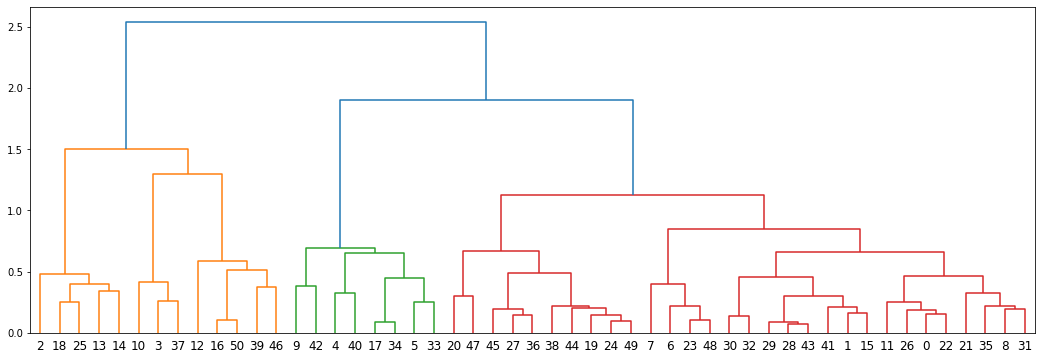

In [213]:
figure(figsize=(18, 6))
linkage_matrix = plot_dendrogram(model)

In [216]:
clustering_model = AgglomerativeClustering(n_clusters=3)
clustering_model.fit(multivariate_x)
clustering_model.labels_

array([1, 1, 0, 0, 2, 2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 1, 2, 1,
       1, 1, 0, 1, 1, 1, 0])

In [140]:
cluster_0 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 0]
cluster_1 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 1]
cluster_2 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 2]

In [141]:
df = important_features_df_scaled.reset_index(drop=True)

In [142]:
cluster_0_ids = df.loc[cluster_0].patient_id.values
cluster_1_ids = df.loc[cluster_1].patient_id.values
cluster_2_ids = df.loc[cluster_2].patient_id.values

In [143]:
def cluster_condition(cluster):
    condition_arr = []
    for pid in cluster:
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        if condition.values[0] == 1.:
            condition_arr.append((pid,1))
        else:
            condition_arr.append((pid,0))
    return condition_arr

In [144]:
condition_arr_cluster_0 = cluster_condition(cluster_0_ids)
condition_arr_cluster_1 = cluster_condition(cluster_1_ids)
condition_arr_cluster_2 = cluster_condition(cluster_2_ids)

In [145]:
def count_high_low_vo2(condition_arr_cluster):
    count_0 = len([ent for ent in condition_arr_cluster if ent[1] == 0])
    count_1 = len([ent for ent in condition_arr_cluster if ent[1] == 1])
    
    return count_0, count_1

In [146]:
count_0_cluster_0, count_1_cluster_0 = count_high_low_vo2(condition_arr_cluster_0)
count_0_cluster_1, count_1_cluster_1 = count_high_low_vo2(condition_arr_cluster_1)
count_0_cluster_2, count_1_cluster_2 = count_high_low_vo2(condition_arr_cluster_2)

In [147]:
print(f'Cluster 0: 0:{count_0_cluster_0},  1:{count_1_cluster_0}')
print(f'Cluster 1: 0:{count_0_cluster_1},  1:{count_1_cluster_1}')
print(f'Cluster 2: 0:{count_0_cluster_2},  1:{count_1_cluster_2}')

Cluster 0: 0:2,  1:11
Cluster 1: 0:14,  1:16
Cluster 2: 0:3,  1:5


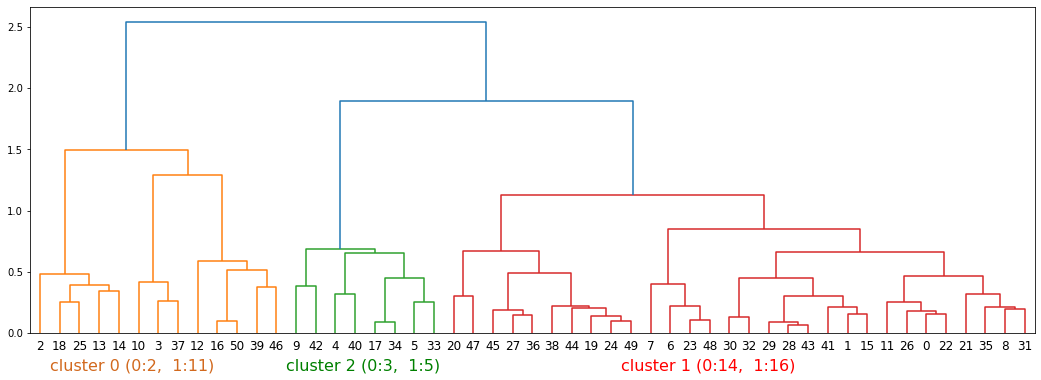

In [159]:
figure(figsize=(18, 6))
linkage_matrix = plot_dendrogram(model)
y_pos = -0.3
plt.text(300,y_pos,f'cluster 1 (0:{count_0_cluster_1},  1:{count_1_cluster_1})',size=16, c='red')
plt.text(10,y_pos,f'cluster 0 (0:{count_0_cluster_0},  1:{count_1_cluster_0})',size=16, c='chocolate');
plt.text(130,y_pos,f'cluster 2 (0:{count_0_cluster_2},  1:{count_1_cluster_2})',size=16, c='green');

### 2D fractals

In [381]:
fractals_2d_csv = pd.read_csv(path+'/Golnoushs_fractals/fractals_2d.csv',header=None)
fractals_2d_csv.head()

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,PatientId,101B,101B,103,103,109,109,113B,113B,114,...,174,174,179,179,181,181,183,183,185,185
1,Phase,ed0,es4,ed0,es3,ed6,es2,ed7,es3,ed11,...,ed0,es3,ed0,es3,ed0,es3,ed0,es4,ed0,es3
2,lv_slope_1,-7.17244797022851e-07,-7.17244797022851e-07,-2.35006480096061,-2.60447083323098,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07,-3.40636875910898e-07,...,1.62022785767115,-4.23819458745847e-07,0.277345495270733,-7.17244797022851e-07,1.6700525232077e-14,1.6700525232077e-14,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07,-7.17244797022851e-07
3,lv_intercept_1,-13.8155093021575,-13.8155093021575,12.6947251769305,13.7171534320888,-13.8155093021575,-13.8155093021575,-13.8155093021575,-13.8155093021575,-13.8155102541196,...,-0.573086769984424,-13.8155100200713,2.89753876193571,-13.8155093021575,-13.8155105579643,-13.8155105579643,-13.8155093021575,-13.8155093021575,-13.8155093021575,-13.8155093021575
4,lv_slope_2,-6.08596281514944e-07,-6.08596281514944e-07,-2.43939199316937,-2.4479288165968,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07,-3.35609746781348e-07,...,0.434298727343355,-1.33087932498926e-07,-0.291314529158718,-6.08596281514944e-07,2.4855571198563e-14,2.4855571198563e-14,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07,-6.08596281514944e-07


In [382]:
fractals_2d_df = fractals_2d_csv.T
header = fractals_2d_df.iloc[0]
fractals_2d_df = fractals_2d_df[1:] #take the data less the header row
fractals_2d_df.columns = header
fractals_2d_df.head()

,PatientId,Phase,lv_slope_1,lv_intercept_1,lv_slope_2,lv_intercept_2,lv_slope_3,lv_intercept_3,lv_slope_4,lv_intercept_4,...,lvmc_slope_21,lvmc_intercept_21,lvmc_slope_22,lvmc_intercept_22,lvmc_slope_23,lvmc_intercept_23,lvmc_slope_24,lvmc_intercept_24,lvmc_avg_slope,lvmc_avg_intercept
1,101B,ed0,-7.17244797022851e-07,-13.8155093021575,-6.08596281514944e-07,-13.815509705509,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,...,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,-6.08596281514944e-07,-13.815509705509,-7.17244797022851e-07,-13.8155093021575,9.41778075697639e-06,-13.8155254939051
2,101B,es4,-7.17244797022851e-07,-13.8155093021575,-6.08596281514944e-07,-13.815509705509,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,...,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,-6.08596281514944e-07,-13.815509705509,-7.17244797022851e-07,-13.8155093021575,9.41778075697639e-06,-13.8155254939051
3,103,ed0,-2.35006480096061,12.6947251769305,-2.43939199316937,12.9484620635241,-2.19220729127321,12.4161561492411,-2.10934424464303,11.967453763633,...,-2.81107435327764,13.327957478684,-3.05523401881432,14.1246362416685,-2.93141522958304,14.0178112699712,-2.98359681478104,14.1905277669756,-3.01555112093158,13.9224312935949
4,103,es3,-2.60447083323098,13.7171534320888,-2.4479288165968,13.1313412419052,-2.38185813403835,13.1508977626358,-2.36853101956377,12.5691216719384,...,-2.86080586867664,13.0201765724558,-3.02104624435245,13.7312840087983,-3.25400883841704,14.3806431536753,-2.99251575713431,14.6044052778162,-3.02894422463501,13.8165311315163
5,109,ed6,-7.17244797022851e-07,-13.8155093021575,-6.08596281514944e-07,-13.815509705509,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,...,-7.34981750675452e-07,-13.8155093109137,-7.61377304336471e-07,-13.8155093940655,-6.08596281514944e-07,-13.815509705509,-7.17244797022851e-07,-13.8155093021575,9.41778075697639e-06,-13.8155254939051


In [383]:
fractals_2d_df_cols = fractals_2d_df.columns

for i in range(2,len(fractals_2d_df_cols)):
    fractals_2d_df[fractals_2d_df_cols[i]] = pd.to_numeric(fractals_2d_df[fractals_2d_df_cols[i]], errors='coerce')

In [384]:
num_rows = fractals_2d_df.shape[0]
for n in range(num_rows//2):
    fractals_2d_df.iat[2*n,1] = 'ed'
    
for n in range(num_rows//2):
    fractals_2d_df.iat[2*n+1,1] = 'es'

In [385]:
fractals_2d_ed = fractals_2d_df[fractals_2d_df.Phase=='ed']
fractals_2d_es = fractals_2d_df[fractals_2d_df.Phase=='es']

In [386]:
fractals_2d_ed.head()

,PatientId,Phase,lv_slope_1,lv_intercept_1,lv_slope_2,lv_intercept_2,lv_slope_3,lv_intercept_3,lv_slope_4,lv_intercept_4,...,lvmc_slope_21,lvmc_intercept_21,lvmc_slope_22,lvmc_intercept_22,lvmc_slope_23,lvmc_intercept_23,lvmc_slope_24,lvmc_intercept_24,lvmc_avg_slope,lvmc_avg_intercept
1,101B,ed,-7.172448e-07,-13.815509,-6.085963e-07,-13.815510,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,...,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,-6.085963e-07,-13.815510,-7.172448e-07,-13.815509,0.000009,-13.815525
3,103,ed,-2.350065e+00,12.694725,-2.439392e+00,12.948462,-2.192207e+00,12.416156,-2.109344e+00,11.967454,...,-2.811074e+00,13.327957,-3.055234e+00,14.124636,-2.931415e+00,14.017811,-2.983597e+00,14.190528,-3.015551,13.922431
5,109,ed,-7.172448e-07,-13.815509,-6.085963e-07,-13.815510,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,...,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,-6.085963e-07,-13.815510,-7.172448e-07,-13.815509,0.000009,-13.815525
7,113B,ed,-7.172448e-07,-13.815509,-6.085963e-07,-13.815510,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,...,-7.349818e-07,-13.815509,-7.613773e-07,-13.815509,-6.085963e-07,-13.815510,-7.172448e-07,-13.815509,0.000009,-13.815525
9,114,ed,-3.406369e-07,-13.815510,-3.356097e-07,-13.815510,-3.642006e-07,-13.815510,-4.502399e-07,-13.815510,...,-3.642006e-07,-13.815510,-4.502399e-07,-13.815510,-3.356097e-07,-13.815510,-3.406369e-07,-13.815510,0.000014,-13.815534


In [388]:
num_rows = fractals_2d_ed.shape[0]
num_cols = fractals_2d_ed.shape[1] - 2
scores = []

for c in range(2,num_cols):
    dyspnea_arr = []
    normal_arr = []

    for r in range(num_rows):
        arr = fractals_2d_ed.iloc[r][fractals_2d_ed.columns[c]]
        pid = fractals_2d_ed.iloc[r]['PatientId']
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        #print(condition.values[0])
        if condition.values[0] == 1.:
            dyspnea_arr.append(arr)
        else:
            normal_arr.append(arr)
    res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
    scores.append((fractals_2d_ed.columns[c], res.pvalue))

In [389]:
significant_scores_ed = [score for score in scores if score[1] < 0.05]
significant_scores_ed = sorted(significant_scores_ed, key=lambda significant_scores_ed: significant_scores_ed[1])

In [390]:
scores = []

for c in range(2,num_cols):
    dyspnea_arr = []
    normal_arr = []

    for r in range(num_rows):
        arr = fractals_2d_es.iloc[r][fractals_2d_es.columns[c]]
        pid = fractals_2d_es.iloc[r]['PatientId']
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        #print(condition.values[0])
        if condition.values[0] == 1.:
            dyspnea_arr.append(arr)
        else:
            normal_arr.append(arr)
    res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
    scores.append((fractals_2d_es.columns[c], res.pvalue))

In [391]:
significant_scores_es = [score for score in scores if score[1] < 0.05]
significant_scores_es = sorted(significant_scores_es, key=lambda significant_scores_es: significant_scores_es[1])

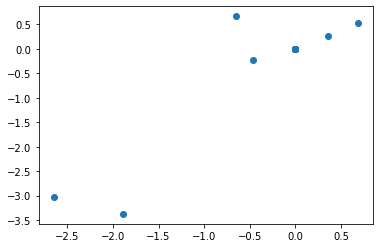

In [392]:
plt.scatter(fractals_2d_es['lv_slope_19'],fractals_2d_es['lvmc_slope_22'])

In [394]:
dyspnea_arr = []
normal_arr = []

for r in range(num_rows):
    arr = fractals_2d_es.iloc[r]['lv_slope_2']
    pid = fractals_2d_es.iloc[r]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    #print(condition.values[0])
    if condition.values[0] == 1.:
        dyspnea_arr.append(arr)
    else:
        normal_arr.append(arr)
scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)


MannwhitneyuResult(statistic=112.5, pvalue=0.024502933797889932)

In [395]:
Counter(dyspnea_arr)

Counter({-6.08596281514944e-07: 16,
         -2.4479288165968: 1,
         -3.35609746781348e-07: 1,
         -1.75320950347884: 1,
         -1.33087932498926e-07: 2,
         -0.36167615891756: 1,
         -0.33555203104179: 1,
         2.4855571198562998e-14: 1})

In [901]:
significant_features_es = [tup[0] for tup in significant_scores_es]
significant_features_ed = [tup[0] for tup in significant_scores_ed]

In [902]:
fractal_2d_es_df = fractals_2d_es[significant_features_es]
fractal_2d_ed_df = fractals_2d_ed[significant_features_ed]

In [904]:
fractal_2d_es_df.to_csv('fractal_2d_es.csv')

In [496]:
pyradiomics_df.tail()

,patient_id,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
33,153,0.836059,0.603425,22.747520,37.697356,45.28751555725382,40.97676226321578,44.368661519139835,47.52637781418398,16024.350598596036,31.517199,0.6656356084013343,4617.793804871596,0.2881735379202313,16389.216062
34,160,0.804688,0.488697,20.452546,41.851167,48.36224584641796,38.77239824817748,39.8122547088205,50.306483983949256,18139.470342993736,33.677135,0.6726870517501865,4963.112552834835,0.2736084603899037,18589.441700
35,162,0.853881,0.656614,22.858465,34.812659,41.12494935826285,41.846861700975836,38.6621989157368,42.11558303313155,14058.838095154613,29.725866,0.7291346587791764,3863.456276699235,0.2748062286904618,14511.193192
36,170,0.939140,0.699115,21.712435,31.057021,35.13803004858957,36.421514166739925,37.5520472144995,38.30851496988675,11637.628531400114,29.166891,0.6760078117892441,3673.7427071801317,0.31567794910000846,11964.333165
37,183,0.871988,0.644199,24.046657,37.328001,37.58015600778645,47.66710664198993,45.37431128953915,48.810404890449,17755.297770818073,32.549587,0.6764737930713922,4865.398924388621,0.2740251944625341,18175.186569


In [1128]:
pyradiomics_columns = pyradiomics_df.columns
pyradiomics_columns

Index(['patient_id', 'original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume'],
      dtype='object')

In [1127]:
pyradiomics_df = pd.read_csv('pyradiomics_es.csv')
pyradiomics_df.drop(columns=['Unnamed: 0'],inplace=True)
pyradiomics_df.head()

,patient_id,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
0,154,0.846270,0.589876,21.747415,36.867750,41.172441,40.575829,41.545532,44.529111,15128.019924,31.200074,0.705137,4194.997683,0.277300,15465.377421
1,109,0.827482,0.693045,25.515435,36.816395,37.180342,43.986822,42.085107,45.808500,17877.388556,30.464913,0.725523,4557.247125,0.254917,18315.559845
2,124,0.330679,0.277249,30.450982,109.832422,109.974052,109.974052,42.815921,111.223571,79053.171768,36.319300,0.711963,12511.414714,0.158266,80542.846188
3,132,0.899642,0.765421,33.697581,44.024887,49.537212,53.875863,47.321540,54.575759,39115.181207,39.606633,0.773094,7208.011916,0.184277,39723.158245
4,174,0.953828,0.866793,34.604688,39.922651,49.421297,47.737684,45.868869,51.434687,33184.321464,38.079349,0.752795,6633.807533,0.199908,33812.263500


In [1129]:
num_features = len(pyradiomics_columns)
num_features

15

In [1130]:
pyradiomics_df.shape

(38, 15)

In [1143]:
numerical_columns = pyradiomics_columns.drop('patient_id').values
pyradiomics_df_scaled = pyradiomics_df.copy(deep=True)
pyradiomics_df_scaled[numerical_columns] = scaler.fit_transform(pyradiomics_df[numerical_columns])

<AxesSubplot:>

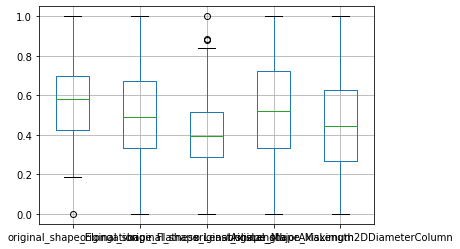

In [1144]:
pyradiomics_df_scaled.boxplot(column = list(numerical_columns)[0:5])

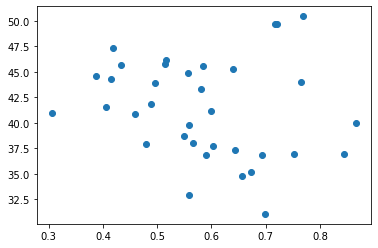

In [1145]:
plt.scatter(pyradiomics_df['original_shape_Flatness'], pyradiomics_df['original_shape_MajorAxisLength'])

<AxesSubplot:>

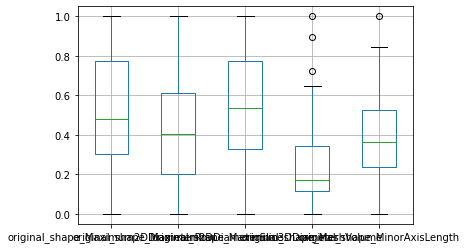

In [1146]:
pyradiomics_df_scaled.boxplot(column = list(numerical_columns)[5:10])

<AxesSubplot:>

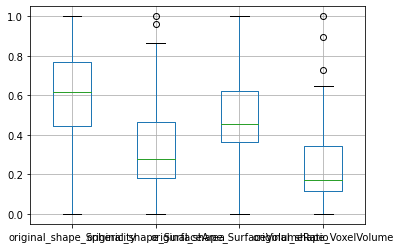

In [1147]:
pyradiomics_df_scaled.boxplot(column = list(numerical_columns)[10:])

In [1142]:
for n in range(1):
    max_idx = pyradiomics_df[numerical_columns[12]].idxmax()
    pyradiomics_df = pyradiomics_df.drop([max_idx])

In [1148]:
u_test_pyradiomics = []
num_rows = pyradiomics_df.shape[0]
for i in range(1,num_features):
    feature = pyradiomics_columns[i]
    dyspnea_arr = []
    normal_arr = []

    for n in range(num_rows):
        arr = pyradiomics_df.iloc[n][feature]
        pid = pyradiomics_df.iloc[n]['patient_id']
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        if condition.values[0] == 1.:
            dyspnea_arr.append(arr)
        else:
            normal_arr.append(arr)
    res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
    print(feature,res.pvalue)
    u_test_pyradiomics.append((feature,res.pvalue)) 

original_shape_Elongation 0.1336004372859304
original_shape_Flatness 0.2983467888625667
original_shape_LeastAxisLength 0.37284612878260937
original_shape_MajorAxisLength 0.1336004372859304
original_shape_Maximum2DDiameterColumn 0.10636577802162994
original_shape_Maximum2DDiameterRow 0.07340022287797351
original_shape_Maximum2DDiameterSlice 0.09139977150182049
original_shape_Maximum3DDiameter 0.05244201934342524
original_shape_MeshVolume 0.28661506663726777
original_shape_MinorAxisLength 0.18281347332454367
original_shape_Sphericity 0.0423501691586338
original_shape_SurfaceArea 0.09436114166625376
original_shape_SurfaceVolumeRatio 0.2751067774726903
original_shape_VoxelVolume 0.28661506663726777


In [1116]:
u_test_pyradiomics = []
num_rows = pyradiomics_df.shape[0]

feature = 'original_shape_Sphericity'
dyspnea_arr = []
normal_arr = []

for n in range(num_rows):
    arr = pyradiomics_df.iloc[n][feature]
    pid = pyradiomics_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_arr.append(arr)
    else:
        normal_arr.append(arr)
res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
print(feature,res.pvalue)
u_test_pyradiomics.append((feature,res.pvalue)) 

u_test_pyradiomics = []
num_rows = pyradiomics_df.shape[0]

feature = 'original_shape_SurfaceArea'
dyspnea_arr1 = []
normal_arr1 = []

for n in range(num_rows):
    arr = pyradiomics_df.iloc[n][feature]
    pid = pyradiomics_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_arr1.append(arr)
    else:
        normal_arr1.append(arr)
res = scipy.stats.mannwhitneyu(dyspnea_arr1,normal_arr1)
print(feature,res.pvalue)
u_test_pyradiomics.append((feature,res.pvalue)) 

original_shape_Sphericity 0.0569122369685371
original_shape_SurfaceArea 0.0569122369685371


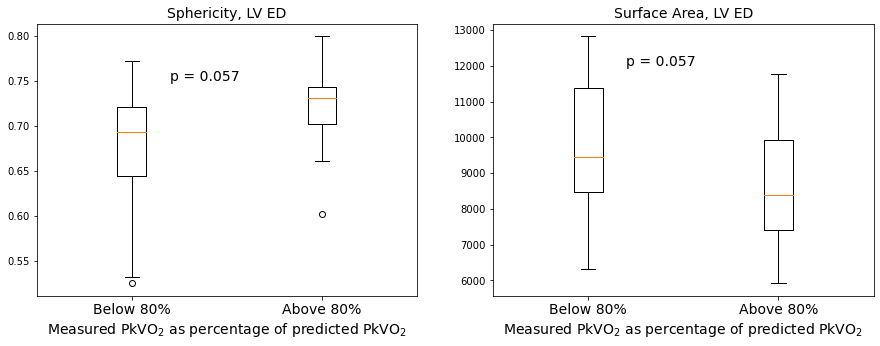

In [1118]:
fig = Figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.set_title('Sphericity, LV ED',fontsize = 14)
ax.set_xlabel('Measured PkVO$_{2}$ as percentage of predicted PkVO$_{2}$',fontsize=14)
ax.boxplot([dyspnea_arr, normal_arr])
ax.set_xticklabels(labels=['Below 80%','Above 80%'],fontsize=14)
ax.text(1.2,0.75,'p = 0.057',fontsize=14)

ax = fig.add_subplot(1,2,2)
ax.set_title('Surface Area, LV ED',fontsize = 14)
ax.set_xlabel('Measured PkVO$_{2}$ as percentage of predicted PkVO$_{2}$',fontsize=14)
ax.boxplot([dyspnea_arr1, normal_arr1])
ax.set_xticklabels(labels=['Below 80%','Above 80%'],fontsize=14)
ax.text(1.2,12000,'p = 0.057',fontsize=14)

fig

In [1149]:
print(len(dyspnea_arr), len(normal_arr))

22 13


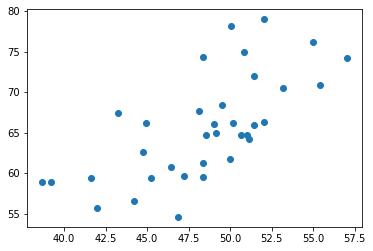

In [793]:
plt.scatter(pyradiomics_df['original_shape_MinorAxisLength'], pyradiomics_df['original_shape_Maximum3DDiameter'])

In [794]:
important_features.append('ed_original_shape_Sphericity')
important_features.append('ed_original_shape_SurfaceArea')
important_features.append('ed_original_shape_Maximum3DDiameter')
important_features.append('ed_original_shape_MinorAxisLength')

In [817]:
important_features.append('es_original_shape_Maximum3DDiameter')
important_features.append('es_original_shape_Sphericity')
important_features.append('es_original_shape_Maximum2DDiameterRow')

In [1072]:
pyradiomics_df, omics_df_common = omics_shape_common(pyradiomics_df)

In [1073]:
pyradiomics_columns = pyradiomics_df.columns
num_features = len(pyradiomics_columns)
num_rows = omics_df_common.shape[0]
u_test = []
for i in range(1, num_features-1):
    G1_arr = []
    G2_arr = []
    feature = pyradiomics_columns[i]

    for n in range(num_rows):
        num_pid = omics_df_common.iloc[n]['EXH']
        omics_record = omics_df_common[omics_df_common['EXH'].values == num_pid]
        condition = omics_record['TranscriptomicGroup']
        pyradiomics_record = pyradiomics_df[pyradiomics_df['PatientId'].values == num_pid]
        arr = pyradiomics_record[feature].values[0]
        if condition.values[0] == 'G1':
            G1_arr.append(arr)
        elif condition.values[0] == 'G2':
            G2_arr.append(arr)
    res = scipy.stats.mannwhitneyu(G1_arr,G2_arr)
    print(feature,res)
    u_test.append((feature,res.pvalue))    

original_shape_Elongation MannwhitneyuResult(statistic=81.0, pvalue=0.3391597059724288)
original_shape_Flatness MannwhitneyuResult(statistic=86.0, pvalue=0.4321973899228302)
original_shape_LeastAxisLength MannwhitneyuResult(statistic=87.0, pvalue=0.4514544553330954)
original_shape_MajorAxisLength MannwhitneyuResult(statistic=86.0, pvalue=0.4321973899228302)
original_shape_Maximum2DDiameterColumn MannwhitneyuResult(statistic=71.0, pvalue=0.18334055953654665)
original_shape_Maximum2DDiameterRow MannwhitneyuResult(statistic=88.0, pvalue=0.47082646508051795)
original_shape_Maximum2DDiameterSlice MannwhitneyuResult(statistic=80.0, pvalue=0.3213064709675931)
original_shape_Maximum3DDiameter MannwhitneyuResult(statistic=90.0, pvalue=0.4902677704948854)
original_shape_MeshVolume MannwhitneyuResult(statistic=71.0, pvalue=0.18334055953654665)
original_shape_MinorAxisLength MannwhitneyuResult(statistic=67.0, pvalue=0.1361267905314994)
original_shape_Sphericity MannwhitneyuResult(statistic=85.0, p

### Important features

In [56]:
important_features

['lvmc_vol_ed',
 'lv_std',
 'min_original_shape_Sphericity',
 'max_original_shape_SurfaceArea',
 'mean_original_shape_Sphericity',
 'mean_original_shape_SurfaceArea',
 'median_original_shape_Sphericity',
 'es_val_original_shape_Sphericity',
 'ed_val_original_shape_SurfaceArea',
 'lv_min_slope',
 'lvmc_min_slope']

In [57]:
pyrads_df = pd.read_csv('pyrads_3d.csv')
pyrads_df.drop(columns=['Unnamed: 0'],inplace=True)
pyrads_df_imp = pyrads_df[['patient_id']+important_features[2:-2]]
pyrads_df_imp.head()

,patient_id,min_original_shape_Sphericity,max_original_shape_SurfaceArea,mean_original_shape_Sphericity,mean_original_shape_SurfaceArea,median_original_shape_Sphericity,es_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea
0,153,0.723153,14611.078910,0.748110,10936.135230,0.748158,0.723153,14611.078910
1,154,0.732408,15848.950767,0.760355,12814.214611,0.767928,0.734934,15848.950767
2,162,0.677365,12633.063217,0.718751,9945.222198,0.712053,0.704503,12633.063217
3,191,0.646605,19440.135711,0.683184,15551.672444,0.685203,0.646605,19440.135711
4,109,0.664806,18885.775024,0.720003,13585.015101,0.728897,0.737380,18885.775024


In [58]:
vol_df = pd.read_csv('vol.csv')
vol_df.drop(columns=['Unnamed: 0'],inplace=True)
vol_df_imp = vol_df[['patient_id']+important_features[:2]]
vol_df_imp.head()

,patient_id,lvmc_vol_ed,lv_std
0,153,85015.500000,7965.467931
1,154,103155.750000,9425.673423
2,162,71071.875000,4889.557224
3,191,103040.360091,6097.426044
4,109,126507.937500,15817.902632


In [59]:
important_features_df = pd.merge(pyrads_df_imp, vol_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,min_original_shape_Sphericity,max_original_shape_SurfaceArea,mean_original_shape_Sphericity,mean_original_shape_SurfaceArea,median_original_shape_Sphericity,es_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea,lvmc_vol_ed,lv_std
0,153,0.723153,14611.078910,0.748110,10936.135230,0.748158,0.723153,14611.078910,85015.500000,7965.467931
1,154,0.732408,15848.950767,0.760355,12814.214611,0.767928,0.734934,15848.950767,103155.750000,9425.673423
2,162,0.677365,12633.063217,0.718751,9945.222198,0.712053,0.704503,12633.063217,71071.875000,4889.557224
3,191,0.646605,19440.135711,0.683184,15551.672444,0.685203,0.646605,19440.135711,103040.360091,6097.426044
4,109,0.664806,18885.775024,0.720003,13585.015101,0.728897,0.737380,18885.775024,126507.937500,15817.902632


In [60]:
fractals_3d_df = pd.read_csv('fractals_3d.csv')
fractals_3d_df.drop(columns=['Unnamed: 0'],inplace=True)
fractals_3d_df_imp = fractals_3d_df[['patient_id']+important_features[-2:]]
fractals_3d_df_imp.head()

,patient_id,lv_min_slope,lvmc_min_slope
0,153,1.963456,2.224151
1,154,2.186582,2.288623
2,162,2.074160,2.137551
3,191,2.322868,2.354578
4,109,2.048207,2.335396


In [61]:
important_features_df = pd.merge(important_features_df, fractals_3d_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,min_original_shape_Sphericity,max_original_shape_SurfaceArea,mean_original_shape_Sphericity,mean_original_shape_SurfaceArea,median_original_shape_Sphericity,es_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea,lvmc_vol_ed,lv_std,lv_min_slope,lvmc_min_slope
0,153,0.723153,14611.078910,0.748110,10936.135230,0.748158,0.723153,14611.078910,85015.500000,7965.467931,1.963456,2.224151
1,154,0.732408,15848.950767,0.760355,12814.214611,0.767928,0.734934,15848.950767,103155.750000,9425.673423,2.186582,2.288623
2,162,0.677365,12633.063217,0.718751,9945.222198,0.712053,0.704503,12633.063217,71071.875000,4889.557224,2.074160,2.137551
3,191,0.646605,19440.135711,0.683184,15551.672444,0.685203,0.646605,19440.135711,103040.360091,6097.426044,2.322868,2.354578
4,109,0.664806,18885.775024,0.720003,13585.015101,0.728897,0.737380,18885.775024,126507.937500,15817.902632,2.048207,2.335396


In [62]:
important_features_df_2 = important_features_df[~important_features_df['patient_id'].isin(low_lv_ef)]
important_features_df_2.shape

(51, 12)

In [63]:
important_features_columns = important_features_df_2.columns
important_features_columns

Index(['patient_id', 'min_original_shape_Sphericity',
       'max_original_shape_SurfaceArea', 'mean_original_shape_Sphericity',
       'mean_original_shape_SurfaceArea', 'median_original_shape_Sphericity',
       'es_val_original_shape_Sphericity', 'ed_val_original_shape_SurfaceArea',
       'lvmc_vol_ed', 'lv_std', 'lv_min_slope', 'lvmc_min_slope'],
      dtype='object')

In [64]:
numerical_columns = important_features_columns.drop('patient_id').values
important_features_df_scaled = important_features_df_2.copy(deep=True)
important_features_df_scaled[numerical_columns] = scaler.fit_transform(important_features_df_2[numerical_columns])

<AxesSubplot:>

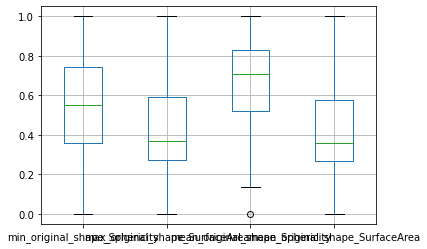

In [65]:
important_features_df_scaled.boxplot(column = list(numerical_columns)[0:4])

<AxesSubplot:>

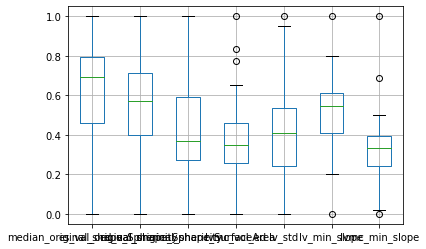

In [66]:
important_features_df_scaled.boxplot(column = list(numerical_columns)[4:])

In [107]:
lv_vol_vo2_max = []
num_rows = important_features_df_2.shape[0]
for n in range(num_rows):
    pid = important_features_df_2.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    lv_vol_vo2_max.append((pid,cpet_record['VO2 (MAX):'].values[0],\
                               cpet_record['dyspnea'].values[0]))

In [108]:
important_features_df_2['pkvo2'] = [ent[1] for ent in lv_vol_vo2_max]
important_features_df_2['dyspnea'] = [ent[2] for ent in lv_vol_vo2_max]

<ipython-input-108-e578456c83a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  important_features_df_2['pkvo2'] = [ent[1] for ent in lv_vol_vo2_max]
<ipython-input-108-e578456c83a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  important_features_df_2['dyspnea'] = [ent[2] for ent in lv_vol_vo2_max]


In [109]:
important_features_df_2.head()

,patient_id,min_original_shape_Sphericity,max_original_shape_SurfaceArea,mean_original_shape_Sphericity,mean_original_shape_SurfaceArea,median_original_shape_Sphericity,es_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea,lvmc_vol_ed,lv_std,lv_min_slope,lvmc_min_slope,pkvo2,dyspnea,petco2
0,153,0.723153,14611.078910,0.748110,10936.135230,0.748158,0.723153,14611.078910,85015.500000,7965.467931,1.963456,2.224151,1.14,1.0,22.0
1,154,0.732408,15848.950767,0.760355,12814.214611,0.767928,0.734934,15848.950767,103155.750000,9425.673423,2.186582,2.288623,1.87,0.0,30.0
2,162,0.677365,12633.063217,0.718751,9945.222198,0.712053,0.704503,12633.063217,71071.875000,4889.557224,2.074160,2.137551,0.59,1.0,14.0
3,191,0.646605,19440.135711,0.683184,15551.672444,0.685203,0.646605,19440.135711,103040.360091,6097.426044,2.322868,2.354578,1.67,1.0,36.0
4,109,0.664806,18885.775024,0.720003,13585.015101,0.728897,0.737380,18885.775024,126507.937500,15817.902632,2.048207,2.335396,1.23,1.0,27.0


In [71]:
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

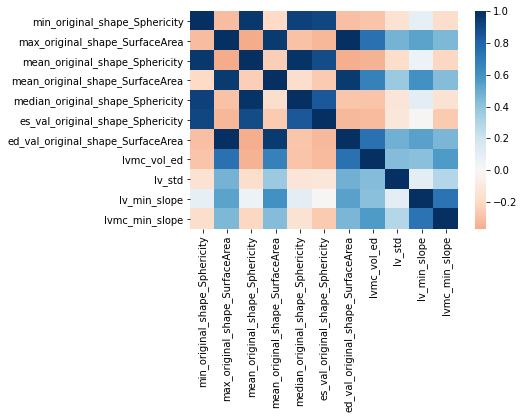

In [110]:
sns.heatmap(important_features_df_2[numerical_columns].corr(),cmap = 'RdBu', center = 0.0);

In [73]:
vif_values = [vif(important_features_df_scaled[numerical_columns].values, i) for i in range(len(numerical_columns))]

In [74]:
vif_feat_vals = {numerical_columns[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
vif_feat_vals

[('max_original_shape_SurfaceArea', 3617.2548391903492),
 ('ed_val_original_shape_SurfaceArea', 3484.250679156462),
 ('mean_original_shape_Sphericity', 619.2193153046816),
 ('median_original_shape_Sphericity', 354.8496053505924),
 ('min_original_shape_Sphericity', 84.95395493638323),
 ('mean_original_shape_SurfaceArea', 70.41163066084502),
 ('es_val_original_shape_Sphericity', 53.90920496602505),
 ('lv_min_slope', 50.37912896831605),
 ('lvmc_min_slope', 21.0850603450062),
 ('lvmc_vol_ed', 14.304093651930348),
 ('lv_std', 7.922187636302196)]

In [155]:
important_features_subset = ['mean_original_shape_SurfaceArea', 'es_val_original_shape_Sphericity', 'lv_std']
vif_values = [vif(important_features_df_scaled[important_features_subset].values, i) for i in range(len(important_features_subset))]
vif_feat_vals = {important_features_subset[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
vif_feat_vals

[('lvmc_vol_ed', 8.376371114102179),
 ('mean_original_shape_SurfaceArea', 7.391392643197346),
 ('lv_std', 5.343783792581146),
 ('es_val_original_shape_Sphericity', 2.982769166966262)]

In [112]:
multivariate_x = important_features_df_scaled[important_features_subset]
multivariate_y = important_features_df_2[['pkvo2']]

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


In [113]:
reg = LinearRegression().fit(multivariate_x, multivariate_y)
reg.score(multivariate_x, multivariate_y)

0.26290732506792824

In [114]:
data = pd.DataFrame({'x0': multivariate_x[important_features_subset[0]], \
                     'x1': multivariate_x[important_features_subset[1]], \
                     'x2': multivariate_x[important_features_subset[2]], \
                     #'x3': multivariate_x[important_features_subset[3]], \
                     'y': multivariate_y.pkvo2.values})

In [115]:
model = ols("y ~ x0 + x1 + x2", data).fit()

In [116]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     5.588
Date:                Thu, 21 Jul 2022   Prob (F-statistic):            0.00231
Time:                        16:42:38   Log-Likelihood:                -37.972
No. Observations:                  51   AIC:                             83.94
Df Residuals:                      47   BIC:                             91.67
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9227      0.294      3.141      0.0

In [83]:
anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)


ANOVA results
            df     sum_sq   mean_sq          F    PR(>F)
x0         1.0   3.613525  3.613525  12.830072  0.000806
x1         1.0   1.098584  1.098584   3.900601  0.054159
x2         1.0   0.009395  0.009395   0.033358  0.855865
Residual  47.0  13.237311  0.281645        NaN       NaN


In [135]:
lv_vol_petco2_max = []
null_petco2_pids = []
num_rows = important_features_df_2.shape[0]
for n in range(num_rows):
    pid = important_features_df_2.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    if not math.isnan(cpet_record['PetCO2.2'].values[0]):
        lv_vol_petco2_max.append((pid,cpet_record['PetCO2.2'].values[0],\
                               cpet_record['dyspnea'].values[0]))
    else:
        null_petco2_pids.append(pid)
null_petco2_pids

['135']

In [141]:
multivariate_x = important_features_df_scaled[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][important_features_subset]
multivariate_y = important_features_df_2[~important_features_df_scaled['patient_id'].isin(null_petco2_pids)][['petco2']]

In [142]:
multivariate_y.shape

(50, 1)

In [143]:
reg = LinearRegression().fit(multivariate_x, multivariate_y)
reg.score(multivariate_x, multivariate_y)

0.2639331566324422

In [145]:
data = pd.DataFrame({'x0': multivariate_x[important_features_subset[0]], \
                     'x1': multivariate_x[important_features_subset[1]], \
                     'x2': multivariate_x[important_features_subset[2]], \
                     #'x3': multivariate_x[important_features_subset[3]], \
                     'y': multivariate_y.petco2.values})

In [146]:
model = ols("y ~ x0 + x1 + x2", data).fit()

In [147]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     5.498
Date:                Thu, 21 Jul 2022   Prob (F-statistic):            0.00259
Time:                        16:56:37   Log-Likelihood:                -152.40
No. Observations:                  50   AIC:                             312.8
Df Residuals:                      46   BIC:                             320.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.4339      2.970      7.217      0.0

### Hierarchical clustering

In [1155]:
important_features_df_scaled.to_csv('important_features_scaled.csv')

In [1183]:
important_features_subset = ['original_shape_Sphericity_x', 'original_shape_Maximum3DDiameter_y', 'lv_std']
important_features_subset.append('pkvo2')
important_features_subset.append('patient_id')
important_features_subset.append('dyspnea')

In [1184]:
important_features_df_scaled[important_features_subset].to_csv('important_features_top3_scaled.csv')

In [1198]:
important_features_df_scaled = important_features_df_scaled.reset_index(drop=True)
important_features_df_scaled = important_features_df_scaled.drop(columns=['level_0','index'])

In [1185]:
pca_top5_cluster1 = [2,32,9,8,19,26,23,27,11,35,30,3,4,18,22,17,1,16,31]
pca_top5_cluster1 = [ent - 1 for ent in pca_top5_cluster1]
pca_top5_cluster1

[1, 31, 8, 7, 18, 25, 22, 26, 10, 34, 29, 2, 3, 17, 21, 16, 0, 15, 30]

In [1217]:
pca_top5_cluster2 = [29, 5, 13, 25, 7, 20, 24, 12, 15]
pca_top5_cluster2 = [ent - 1 for ent in pca_top5_cluster2]
pca_top5_cluster2

[28, 4, 12, 24, 6, 19, 23, 11, 14]

In [1201]:
pca_top5_cluster1_df = important_features_df_scaled.iloc[pca_top5_cluster1]

In [1227]:
print(sum(pca_top5_cluster1_df['dyspnea']), \
      sum(pca_top5_cluster1_df['dyspnea'])/pca_top5_cluster1_df['dyspnea'].shape[0], \
      pca_top5_cluster1_df['dyspnea'].shape)

11.0 0.5789473684210527 (19,)


In [1222]:
12/16

0.75

In [1223]:
pca_top5_cluster2_df = important_features_df_scaled.iloc[pca_top5_cluster2]

In [1228]:
print(sum(pca_top5_cluster2_df['dyspnea']), \
      sum(pca_top5_cluster2_df['dyspnea'])/pca_top5_cluster2_df['dyspnea'].shape[0], \
      pca_top5_cluster2_df['dyspnea'].shape)

8.0 0.8888888888888888 (9,)


In [1208]:
top3_cluster1 = [31, 27, 23, 8, 6, 19, 14, 33, 18, 1, 4, 16, ]
top3_cluster1 = [ent - 1 for ent in top3_cluster1]
top3_cluster1

[30, 26, 22, 7, 5, 18, 13, 32, 17, 0, 3, 15, 21, 25, 16, 33, 1]

In [1209]:
top3_cluster1_df = important_features_df_scaled.iloc[top3_cluster1]

In [1210]:
top3_cluster1_df.shape

(17, 15)

In [1211]:
sum(top3_cluster1_df.dyspnea)

8.0

In [1212]:
8/17

0.47058823529411764

In [1213]:
15/18

0.8333333333333334

In [1214]:
sorted(pca_top5_cluster1)

[0, 1, 2, 3, 7, 8, 10, 15, 16, 17, 18, 21, 22, 25, 26, 29, 30, 31, 34]

In [1215]:
sorted(top3_cluster1)

[0, 1, 3, 5, 7, 13, 15, 16, 17, 18, 21, 22, 25, 26, 30, 32, 33]

In [1216]:
set(pca_top5_cluster1) - set(top3_cluster1)

{2, 8, 10, 29, 31, 34}

In [649]:
num_rows = len(patient_ids)
dyspnea_x_arr = []
dyspnea_y_arr = []
normal_x_arr = []
normal_y_arr = []

for n in range(num_rows):
    x = lvmc_df.iloc[n]['lvmc_snr']
    y = lvmc_df.iloc[n]['lv_std']
    pid = lvmc_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_x_arr.append(x)
        dyspnea_y_arr.append(y)
    else:
        normal_x_arr.append(x)
        normal_y_arr.append(y)

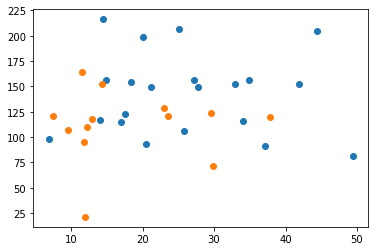

In [650]:
plt.scatter(dyspnea_x_arr, dyspnea_y_arr)
plt.scatter(normal_x_arr, normal_y_arr)

In [702]:
imp_features = imp_features_df.columns[1:3]
scaler = RobustScaler()
lvmc_scaled = scaler.fit_transform(imp_features_df[imp_features])
embedded = TSNE(n_components=2, perplexity = 7, random_state=0).fit_transform(lvmc_scaled)

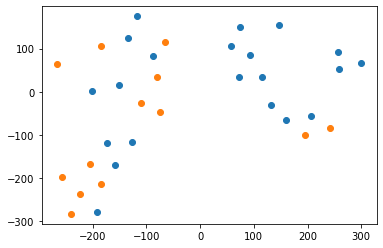

In [703]:
num_rows = len(patient_ids)
dyspnea_x_arr = []
dyspnea_y_arr = []
normal_x_arr = []
normal_y_arr = []

for n in range(num_rows):
    pid = lvmc_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_x_arr.append(embedded[n,0])
        dyspnea_y_arr.append(embedded[n,1])
    else:
        normal_x_arr.append(embedded[n,0])
        normal_y_arr.append(embedded[n,1])
plt.scatter(dyspnea_x_arr,dyspnea_y_arr)
plt.scatter(normal_x_arr,normal_y_arr)

### Omics data

In [58]:
omics_df.shape

(56, 315)

In [294]:
len(cpet_ids)

67

In [436]:
cpet_ids = cpet_data['Record ID'].values
omics_ids = omics_df['EXH'].values

In [465]:
lvmc_df = pd.read_csv('lvmc.csv')
lvmc_df.drop(columns=['Unnamed: 0'],inplace=True)

In [470]:
lvmc_df.shape

(38, 15)

In [438]:
condition = []
for i in range(omics_df_common.shape[0]):
    pid = omics_df_common.iloc[i]['EXH']
    cpet_record = cpet_data[cpet_data['Record ID'].values == pid]
    condition.append(cpet_record['dyspnea'].values[0])
omics_df_common['dyspnea'] = condition

<ipython-input-438-616bb09829ff>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omics_df_common['dyspnea'] = condition


In [248]:
G1_0 = omics_df_common[(omics_df_common['TranscriptomicGroup'] == 'G1') & (omics_df_common['dyspnea'] == 0)]
G1_1 = omics_df_common[(omics_df_common['TranscriptomicGroup'] == 'G1') & (omics_df_common['dyspnea'] == 1)]
G2_0 = omics_df_common[(omics_df_common['TranscriptomicGroup'] == 'G2') & (omics_df_common['dyspnea'] == 0)]
G2_1 = omics_df_common[(omics_df_common['TranscriptomicGroup'] == 'G2') & (omics_df_common['dyspnea'] == 1)]

In [249]:
print(round(G1_1.shape[0]/(G1_0.shape[0] + G1_1.shape[0]),2), G1_0.shape[0] + G1_1.shape[0])

0.53 17


In [250]:
print(round(G2_1.shape[0]/(G2_0.shape[0] + G2_1.shape[0]),2), G2_0.shape[0] + G2_1.shape[0])

0.85 13


#### Transcriptomics and volume

In [473]:
lvmc_columns = lvmc_df.columns
num_features = len(lvmc_columns)
num_rows = omics_df_common.shape[0]
u_test = []
for i in range(1, num_features-1):
    G1_arr = []
    G2_arr = []
    feature = lvmc_columns[i]

    for n in range(num_rows):
        num_pid = omics_df_common.iloc[n]['EXH']
        omics_record = omics_df[omics_df['EXH'].values == num_pid]
        condition = omics_record['TranscriptomicGroup']
        lvmc_record = lvmc_df[lvmc_df['PatientId'].values == num_pid]
        arr = lvmc_record[feature]
        if condition.values[0] == 'G1':
            G1_arr.append(arr)
        elif condition.values[0] == 'G2':
            G2_arr.append(arr)
    res = scipy.stats.mannwhitneyu(G1_arr,G2_arr)
    print(feature,res)
    u_test.append((feature,res.pvalue))    

lvmc_std MannwhitneyuResult(statistic=99.0, pvalue=0.32262559485719755)
lvmc_snr MannwhitneyuResult(statistic=89.0, pvalue=0.18973133253557573)
lvmc_vol_es MannwhitneyuResult(statistic=93.0, pvalue=0.23839348893417223)
lvmc_vol_ed MannwhitneyuResult(statistic=85.0, pvalue=0.14771270569348166)
lvmc_vol_max MannwhitneyuResult(statistic=90.0, pvalue=0.2012864382885166)
lvmc_vol_es_equal_max MannwhitneyuResult(statistic=108.0, pvalue=0.4484411157100462)
lvmc_vol_max_minus_min MannwhitneyuResult(statistic=99.0, pvalue=0.32262559485719755)
lv_vol_ed MannwhitneyuResult(statistic=88.0, pvalue=0.1785934759050451)
lv_vol_es MannwhitneyuResult(statistic=91.5, pvalue=0.21936383003257448)
lv_std MannwhitneyuResult(statistic=87.0, pvalue=0.167876586815425)
lv_snr MannwhitneyuResult(statistic=88.0, pvalue=0.1785934759050451)
stroke_volume MannwhitneyuResult(statistic=67.0, pvalue=0.03594409539173697)
ejection_fraction MannwhitneyuResult(statistic=75.0, pvalue=0.0714862030778371)


####  Transcriptomics and 3d fractal features

In [474]:
fractals_df = pd.read_csv('fractals.csv')
fractals_df.drop(columns=['Unnamed: 0', 'num_scales'],inplace=True)
fractals_df.head()

,patient_id,lv_slope,lvmc_slope,lv_intcpt,lvmc_intcpt
0,154,2.400632,2.375353,7.380163,7.525783
1,109,2.536951,2.347765,7.755386,7.537170
2,124,2.348588,2.274783,7.292024,7.490571
3,132,2.506089,2.331482,7.751648,7.585065
4,174,2.395402,2.327337,7.435886,7.492494


In [475]:
fractals_df, omics_df_common = omics_shape_common(fractals_df)

In [477]:
fractals_columns = fractals_df.columns
num_features = len(fractals_columns)
num_rows = omics_df_common.shape[0]
u_test = []

for i in range(1, num_features-1):
    G1_arr = []
    G2_arr = []
    feature = fractals_columns[i]

    for n in range(num_rows):
        num_pid = omics_df_common.iloc[n]['EXH']
        condition = omics_record['TranscriptomicGroup']
        fractals_record = fractals_df[fractals_df['PatientId'].values == num_pid]
        arr = fractals_record[feature]
        omics_record = omics_df[omics_df['EXH'].values == num_pid]
        if condition.values[0] == 'G1':
            G1_arr.append(arr)
        elif condition.values[0] == 'G2':
            G2_arr.append(arr)
    res = scipy.stats.mannwhitneyu(G1_arr,G2_arr)
    print(feature,res)
    u_test.append((feature,res.pvalue))    

lv_slope MannwhitneyuResult(statistic=94.0, pvalue=0.25154747180134696)
lvmc_slope MannwhitneyuResult(statistic=102.0, pvalue=0.36888269459098477)
lv_intcpt MannwhitneyuResult(statistic=87.0, pvalue=0.167876586815425)
lvmc_intcpt MannwhitneyuResult(statistic=100.0, pvalue=0.337784391244448)


#### Transcriptomics and Pyradiomics

In [478]:
pyradiomics_df = pd.read_csv('pyradiomics_ed.csv')
pyradiomics_df.drop(columns=['Unnamed: 0'],inplace=True)

In [489]:
pyradiomics_df, omics_df_common = omics_shape_common(pyradiomics_df)

In [490]:
pyradiomics_columns = pyradiomics_df.columns
num_features = len(pyradiomics_columns)
num_rows = omics_df_common.shape[0]
u_test = []

for i in range(1, num_features-1):
    G1_arr = []
    G2_arr = []
    feature = pyradiomics_columns[i]

    for n in range(num_rows):
        num_pid = omics_df_common.iloc[n]['EXH']
        condition = omics_record['TranscriptomicGroup']
        pyradiomics_record = pyradiomics_df[pyradiomics_df['PatientId'].values == num_pid]
        arr = pyradiomics_record[feature]
        omics_record = omics_df[omics_df['EXH'].values == num_pid]
        if condition.values[0] == 'G1':
            G1_arr.append(arr)
        elif condition.values[0] == 'G2':
            G2_arr.append(arr)
    res = scipy.stats.mannwhitneyu(G1_arr,G2_arr)
    print(feature,res)
    u_test.append((feature,res.pvalue))    

original_shape_Elongation MannwhitneyuResult(statistic=94.0, pvalue=0.25154747180134696)
original_shape_Flatness MannwhitneyuResult(statistic=109.0, pvalue=0.4833084396474358)
original_shape_LeastAxisLength MannwhitneyuResult(statistic=102.0, pvalue=0.36888269459098477)
original_shape_MajorAxisLength MannwhitneyuResult(statistic=80.0, pvalue=0.10463912228778027)
original_shape_Maximum2DDiameterColumn MannwhitneyuResult(statistic=93.0, pvalue=0.23839348893417223)
original_shape_Maximum2DDiameterRow MannwhitneyuResult(statistic=86.0, pvalue=0.15758279778229567)
original_shape_Maximum2DDiameterSlice MannwhitneyuResult(statistic=69.0, pvalue=0.04293094619231421)
original_shape_Maximum3DDiameter MannwhitneyuResult(statistic=80.0, pvalue=0.10463912228778027)
original_shape_MeshVolume MannwhitneyuResult(statistic=99.0, pvalue=0.32262559485719755)
original_shape_MinorAxisLength MannwhitneyuResult(statistic=66.0, pvalue=0.0327758387997592)
original_shape_Sphericity MannwhitneyuResult(statistic=

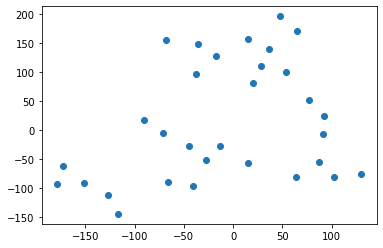

In [523]:
lvmc_df_features = lvmc_df.columns[2:8]
scaler = RobustScaler()
lvmc_scaled = scaler.fit_transform(lvmc_df[lvmc_df_features])
embedded = TSNE(n_components=2, perplexity = 7, random_state=0).fit_transform(lvmc_scaled)
plt.scatter(embedded[:,0],embedded[:,1])

In [245]:
condition = []
transcriptomics = []
for i in range(common_df.shape[0]):
    pid = common_df.iloc[i]['PatientId']
    cpet_record = cpet_data[cpet_data['Record ID'].values == pid]
    condition.append(cpet_record['dyspnea'].values[0])
    omics_record = omics_df[omics_df['EXH'].values == pid]
    transcriptomics.append(omics_record['TranscriptomicGroup'].values[0])
    #print(omics_record['TranscriptomicGroup'].values[0])
common_df['dyspnea'] = condition
common_df['TranscriptomicGroup'] = transcriptomics

<ipython-input-245-de906f1de7dd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df['dyspnea'] = condition
<ipython-input-245-de906f1de7dd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df['TranscriptomicGroup'] = transcriptomics


In [247]:
common_df_features = common_df.columns[2:9]
scaler = RobustScaler()
lvmc_scaled = scaler.fit_transform(common_df[common_df_features])
embedded = TSNE(n_components=2, perplexity = 7, random_state=0).fit_transform(lvmc_scaled)

num_rows = len(embedded)
dyspnea_arr = []
normal_arr = []
G1_arr = []
G2_arr = []

for n in range(num_rows):
    dyspnea = common_df.iloc[n]['dyspnea']
    TranscriptomicGroup = common_df.iloc[n]['TranscriptomicGroup']
    
    if dyspnea == 1:
        dyspnea_arr.append(embedded[n])
    else:
        normal_arr.append(embedded[n])

    if TranscriptomicGroup == 'G1':
        G1_arr.append(embedded[n])
    elif TranscriptomicGroup == 'G2':
        G2_arr.append(embedded[n])

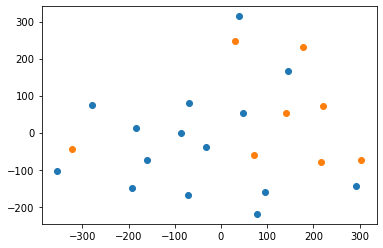

In [248]:
arr1 = dyspnea_arr
x1 = [vals[0] for vals in arr1]
y1 = [vals[1] for vals in arr1]

arr2 = normal_arr
x2 = [vals[0] for vals in arr2]
y2 = [vals[1] for vals in arr2]

plt.scatter(x1,y1)
plt.scatter(x2,y2)

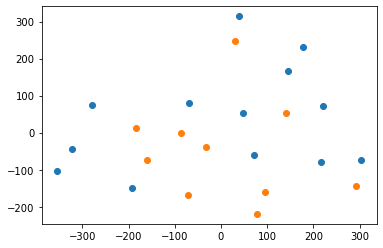

In [249]:
arr1 = G1_arr
x1 = [vals[0] for vals in arr1]
y1 = [vals[1] for vals in arr1]

arr2 = G2_arr
x2 = [vals[0] for vals in arr2]
y2 = [vals[1] for vals in arr2]

plt.scatter(x1,y1)
plt.scatter(x2,y2)

### Annotations vs nnUNet

In [1025]:
patient_id = '181'
raw_images_prefix = 'EXH'+patient_id+'_CINE_SET-UP-8SAX-1RTVLA-1HLA_'
raw_images_suffix = '__0000.nii.gz'

In [1026]:
n_slices

10

In [1027]:
patient_folder = f'/Users/saurabh/Desktop/sample/uh_images/EXH{patient_id}/REST/'
gt_folder = patient_folder + 'annotations/'
segment_folder = patient_folder + 'all_slices/'
num_files = len(glob.glob(gt_folder+'*'))

sample_file = gt_folder + raw_images_prefix + str(0).zfill(4) + '__0000.nii.gz'
sample = nib.load(sample_file).get_fdata()  
n_slices = sample.shape[2]

dice = np.zeros((num_files,n_slices,3))

#for t_slice in range(num_files):
for t_slice in range(num_files):
    gt_file = gt_folder + raw_images_prefix + str(t_slice).zfill(4) + '__0000.nii.gz'
    segment_file = segment_folder + raw_images_prefix + str(t_slice).zfill(4) + '.nii.gz'
    #print(gt_file, '\n', segment_file)
    gt_all = nib.load(gt_file).get_fdata()  
    segment_all = nib.load(segment_file).get_fdata()  
    
    for z_slice in range(n_slices):
        for cardiac_comp in range(1,4):
            gt = np.array(gt_all[:,:,z_slice])
            segment = np.array(segment_all[:,:,z_slice])
            segment = np.where(segment == cardiac_comp, 1, 0)
            gt = np.where(gt == cardiac_comp, 1, 0)

            dice[t_slice,z_slice,cardiac_comp-1] = \
            np.sum(segment[gt==1])*2.0 / (np.sum(segment) + np.sum(gt))

<ipython-input-1027-40b9a0a350fc>:28: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(segment[gt==1])*2.0 / (np.sum(segment) + np.sum(gt))


In [1029]:
dice[3,:,1:3]

array([[       nan,        nan],
       [       nan,        nan],
       [0.84594595, 0.89189189],
       [0.86279357, 0.88888889],
       [0.88888889, 0.90801187],
       [0.83464567, 0.88817891],
       [0.848     , 0.82424242],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan]])

Problematic images: 101B, 109 

### Black pixel patients

In [352]:
import pydicom as dicom


In [360]:
path = '/Users/saurabh/Desktop/sample/uh_images/EXH132/CINE_SET-UP-8SAX-1RTVLA-1HLA/'

In [361]:
num_folders = glob.glob(path + '*')
len(num_folders)

10

In [362]:
dcm_folder = num_folders[0]
num_dcm = glob.glob(dcm_folder+'/*')
dcm_file = num_dcm[0]

In [353]:
dcm_array = dicom.dcmread(dcm_file)

In [363]:
for i in range(len(num_dcm)):
    dcm_file = num_dcm[0]
    dcm_array = dicom.dcmread(dcm_file)    
    print(dcm_array.pixel_array.shape)

(160, 124)
(160, 124)
(160, 124)
(160, 124)
(160, 124)
(160, 124)
(160, 124)
(160, 124)
(160, 124)
(160, 124)
(160, 124)
(160, 124)
(160, 124)


### Removing bad slices

In [35]:
ed_or_es = 0
bad_slice = 7
bad_maskName = nnunet_folder + nnunet_images_prefix + str(ed_or_es).zfill(4) + nnunet_images_suffix

origin, spacing, arr = nii_to_arr(bad_maskName)

#good_mask_arr = np.concatenate((arr[:bad_slice,:,:],arr[bad_slice+1:,:,:]),axis=0)
arr[bad_slice,:,:] = 0
good_mask_arr = arr
arr_to_nii(origin, spacing, good_mask_arr, bad_maskName)

In [343]:
bad_arr = arr[3,:,:]

In [344]:
bad_arr.shape

(160, 124)

In [345]:
bad_arr[94,90] = 0
bad_arr[93,90] = 0
bad_arr[93,89] = 0

In [346]:
arr[3,:,:] = bad_arr

In [347]:
arr_to_nii(origin, spacing, arr, bad_maskName)

### Read 'shape.csv' file generated by matlab

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from collections import Counter

In [13]:
path = os.getcwd()
path

'/Users/saurabh/Desktop/HeartProjects/Exhalted/Params/Code_EXH'

In [942]:
shape_csv_file = path + '/shape.csv'
shape_csv = pd.read_csv(shape_csv_file,header=None)

In [945]:
shape_df = shape_csv.T
header = shape_df.iloc[0]
shape_df = shape_df[1:] #take the data less the header row
shape_df.columns = header
shape_df.head()

,PatientId,MaskType,Phase,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,...,lvmc_std_compactness,lvmc_avg_convexity,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,lvmc_volume
1,103,nnunet,ed0,0.88153894732592,0.0331195277485109,0.840172086413143,0.0554470159578379,13.224270909007,0.285613858454861,0.962706816226651,...,2.77733248059227,0.96343057982393,0.0048888890653635,1.09891023441098,0.0681088643943254,20.5773683463314,3.58045980481536,0.0351569917589735,0.00993217117484051,2131
2,103,nnunet,es3,0.838511496560822,0.0573751417362971,0.78353951643338,0.0967877094760936,13.0438026856671,0.242789084318378,0.967902957801785,...,2.69924138976291,0.960595613237505,0.00632349355485873,1.14948672127322,0.0616121411100028,19.7419737335535,3.86968977839554,0.0303566563488453,0.00833519621369487,2593
3,101B,nnunet,ed0,0.86847872175284,0.0343411307691129,0.829262912407044,0.0669926426786354,12.9528831838857,0.501050277019675,0.969982653795967,...,2.82829155928824,0.962835846524738,0.00238893973329938,1.11259657476128,0.0192278421664071,18.2415931234413,2.72851563450739,0.0342178692297371,0.00652940711638101,1618
4,101B,nnunet,es4,0.866036051162755,0.0334725155837084,0.885459277383243,0.069679797723784,12.1536902210571,0.833339637083652,0.970200012646485,...,2.16232554984771,0.96791592068012,0.00977154528163414,1.10551352279248,0.111537020314993,14.9243433547844,3.60342281625912,0.0503464064685728,0.0133017137244453,1487
5,109,nnunet,ed6,0.860426222391012,0.035081843073099,0.806526009237852,0.0717694371037641,13.1802029190702,0.248524622416157,0.965764164016044,...,1.36356377289983,0.960202275897299,0.00774513758551126,1.0796047454818,0.0205769156639994,19.7193227796413,1.81034048978824,0.0523012327184311,0.0179177212773061,1275


In [713]:
shape_df = shape_csv.drop(columns=['Unnamed: 0'])
shape_df.tail()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_max,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_vol_ed,lv_std,lv_snr,lv_vol_max_minus_min
29,126,12.833581,34.889652,1558.0,1606.0,0,0.091532,2599.0,155.856124,3.673973,0.560215
30,162,17.594166,20.491796,947.0,1104.0,0,0.142210,1203.0,93.590771,3.089647,0.663342
31,134,39.959680,12.264608,1664.0,1667.0,0,0.279544,2020.0,109.749624,4.192373,0.530198
32,153,11.121230,37.092886,1290.0,1290.0,1,0.072868,1570.0,91.584557,4.045240,0.517197
33,160,13.249102,44.347413,1922.0,2032.0,0,0.083661,2550.0,204.493826,2.741631,0.740784


In [750]:
sorted(shape_df['patient_id'])

['101B',
 '103',
 '109',
 '113B',
 '114',
 '124',
 '126',
 '129',
 '130',
 '132',
 '134',
 '136A',
 '141',
 '142',
 '143',
 '147',
 '149',
 '150',
 '151',
 '153',
 '154',
 '157',
 '158',
 '159',
 '160',
 '161',
 '162',
 '164',
 '167',
 '168',
 '174',
 '179',
 '181',
 '185']

In [709]:
# shape_df = shape_csv.T
# header = shape_df.iloc[0]
# shape_df = shape_df[1:] #take the data less the header row
# shape_df.columns = header
# shape_df.head()

,NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
1,patient_id,159,181,149,103,113B,132,109,151,129,...,164,142,147,185,136A,126,162,134,153,160
2,lvmc_std,46.680098008343855,17.086813151476473,30.076172826259,49.40284404768616,18.40749677441232,14.905681314768607,29.95029896617503,31.60246903934432,36.08779572099132,...,29.82969236976808,28.4763761739446,10.67298160980092,32.44444444444444,26.695354938802407,12.83358134680983,17.594166291700212,39.95967967839582,11.12122996030133,13.249101581324162
3,lvmc_snr,7.420880036401995,32.93704304726412,18.43078657243435,14.8202428579226,27.768567378523667,34.00931260879662,20.04011992723376,17.593562050730696,22.959240185977112,...,21.22023733389088,16.986079546945103,49.42165543153908,9.582191780821915,25.139621205621555,34.88965222705157,20.491796205630298,12.26460761740946,37.09288630763475,44.347413038449595
4,lvmc_vol_es,1262.0,1514.0,1500.0,2593.0,1429.0,1717.0,1646.0,1814.0,2766.0,...,1857.0,1648.0,1388.0,953.0,2077.0,1558.0,947.0,1664.0,1290.0,1922.0
5,lvmc_vol_max,1271.0,1567.0,1701.0,2593.0,1536.0,1950.0,1679.0,1814.0,2782.0,...,1881.0,1723.0,1447.0,1074.0,2091.0,1606.0,1104.0,1667.0,1290.0,2032.0


In [714]:
shape_df.shape

(34, 11)

In [124]:
Counter(cpet_data['dyspnea'])

NameError: name 'Counter' is not defined

In [723]:
numerical_cols = shape_df.columns.drop(['patient_id'])
numerical_cols

Index(['lvmc_std', 'lvmc_snr', 'lvmc_vol_es', 'lvmc_vol_max',
       'lvmc_vol_es_equal_max', 'lvmc_vol_max_minus_min', 'lv_vol_ed',
       'lv_std', 'lv_snr', 'lv_vol_max_minus_min'],
      dtype='object')

In [950]:
# for column in numerical_cols.values:
#     shape_df[column] = pd.to_numeric(shape_df[column],downcast='float')

In [951]:
num_rows = shape_df.shape[0]
for n in range(num_rows//2):
    shape_df.iat[2*n,2] = 'ed'
    
for n in range(num_rows//2):
    shape_df.iat[2*n+1,2] = 'es'

In [999]:
shape_df_ed = shape_df[shape_df.Phase=='ed']
shape_df_es = shape_df[shape_df.Phase=='es']

In [1000]:
shape_df_ed.shape

(30, 33)

In [1007]:
shape_df_ed.head()

,PatientId,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,...,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,lvmc_volume,lvmc_snr,lv_std
1,103,0.88153894732592,0.0331195277485109,0.840172086413143,0.0554470159578379,13.224270909007,0.285613858454861,0.962706816226651,0.00822368656178258,1.04521708080344,...,0.0048888890653635,1.09891023441098,0.0681088643943254,20.5773683463314,3.58045980481536,0.0351569917589735,0.00993217117484051,2131,14.820243,156.399901
3,101B,0.86847872175284,0.0343411307691129,0.829262912407044,0.0669926426786354,12.9528831838857,0.501050277019675,0.969982653795967,0.00469043919351196,0.931872587707331,...,0.00238893973329938,1.11259657476128,0.0192278421664071,18.2415931234413,2.72851563450739,0.0342178692297371,0.00652940711638101,1618,6.849858,98.109454
5,109,0.860426222391012,0.035081843073099,0.806526009237852,0.0717694371037641,13.1802029190702,0.248524622416157,0.965764164016044,0.00530538222538663,0.864018626384226,...,0.00774513758551126,1.0796047454818,0.0205769156639994,19.7193227796413,1.81034048978824,0.0523012327184311,0.0179177212773061,1275,20.040120,198.567112
7,114,0.876474983162724,0.0245228722513664,0.868086804777521,0.0519461362144857,12.6749245829662,0.504968362996531,0.966812500371386,0.00630241299365371,0.889317289062329,...,0.00719907447212849,1.10644436464164,0.094579798024782,16.8509669851833,3.81171479962352,0.0376744302373261,0.00658236957265296,1448,11.948146,21.286028
9,124,0.887692386001172,0.01374953195451,0.8755550971902,0.040088956712743,12.8119431382477,0.34298619452668,0.96707808661328,0.00659228480341661,0.95210590249932,...,0.00434557093496138,1.19210260586449,0.0874938132436449,17.8983804608589,1.96763259165974,0.0337335900255452,0.00733743376262725,1581,29.820123,71.457336


In [1002]:
condition = []
for i in range(shape_df_ed.shape[0]):
    pid = shape_df_ed.iloc[i]['PatientId']
    cpet_record = cpet_data[cpet_data['Record ID'].values == int(pid[0:3])]
    condition.append(int(cpet_record['dyspnea'].values[0]))

'lvmc_snr', 'lv_std'

In [1072]:
lvmc_df.head()

,Unnamed: 0,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_max,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_vol_ed,lv_std,lv_snr,lv_vol_max_minus_min
0,0,159,46.680098,7.420880,1262.0,1271.0,0,0.282455,1951.0,120.427644,3.242765,0.588929
1,1,181,17.086813,32.937043,1514.0,1567.0,0,0.087428,1997.0,151.900708,3.317527,0.575864
2,2,149,30.076173,18.430787,1500.0,1701.0,0,0.156379,2251.0,154.196075,3.837711,0.513550
3,3,103,49.402844,14.820243,2593.0,2593.0,1,0.178172,3004.0,156.399901,4.654657,0.483688
4,4,113B,18.407497,27.768567,1429.0,1536.0,0,0.097005,1400.0,149.498302,1.874800,0.817143


In [1003]:
lvmc_snr = []
lv_std = []
for i in range(shape_df_ed.shape[0]):
    pid = shape_df_ed.iloc[i]['PatientId']
    lvmc_record = lvmc_df[lvmc_df['patient_id'].values == pid]
    lvmc_snr.append(lvmc_record['lvmc_snr'].values[0])
    lv_std.append(lvmc_record['lv_std'].values[0])    

In [1004]:
shape_df_es = shape_df_es.drop(columns=['MaskType', 'Phase'])

In [1005]:
shape_df_ed = shape_df_ed.drop(columns=['MaskType', 'Phase'])

In [1006]:
shape_df_es['lvmc_snr'] = lvmc_snr
shape_df_ed['lvmc_snr'] = lvmc_snr

shape_df_es['lv_std'] = lv_std
shape_df_ed['lv_std'] = lv_std

In [1008]:
shape_cols = shape_df_es.columns

for i in range(1,len(shape_cols)):
    shape_df_es[shape_cols[i]] = pd.to_numeric(shape_df_es[shape_cols[i]], errors='coerce')
    shape_df_ed[shape_cols[i]] = pd.to_numeric(shape_df_ed[shape_cols[i]], errors='coerce')    

In [1009]:
shape_df_es['condition'] = condition
shape_df_ed['condition'] = condition

In [1010]:
shape_df_es.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 2 to 60
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PatientId                      30 non-null     object 
 1   lv_avg_average_radial_ratio    30 non-null     float64
 2   lv_std_average_radial_ratio    30 non-null     float64
 3   lv_avg_area_overlap_ratio      30 non-null     float64
 4   lv_std_area_overlap_ratio      30 non-null     float64
 5   lv_avg_compactness             30 non-null     float64
 6   lv_std_compactness             30 non-null     float64
 7   lv_avg_convexity               30 non-null     float64
 8   lv_std_convexity               30 non-null     float64
 9   lv_avg_Hausdorff_Dimension     30 non-null     float64
 10  lv_std_Hausdorff_Dimension     30 non-null     float64
 11  lv_avg_smoothness              30 non-null     float64
 12  lv_std_smoothness              30 non-null     float

In [1012]:
#shape_df_es.to_csv('shape_es.csv')
#shape_df_ed.to_csv('shape_ed.csv')

In [1260]:
shape_df_ed.shape

(30, 34)

In [1251]:
shape_df_ed_scaled = shape_df_ed.drop(columns=['PatientId', 'condition'])

In [1252]:
shape_df_ed_scaled_arr = StandardScaler().fit_transform(shape_df_ed_scaled)

In [1253]:
df = pd.DataFrame(data = shape_df_ed_scaled_arr, columns = shape_df_ed_scaled.columns)

In [1257]:
df['PatientId'] = shape_df_ed['PatientId'].values
df['condition'] = shape_df_ed['condition'].values
df.head()

,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,lv_std_Hausdorff_Dimension,...,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,lvmc_volume,lvmc_snr,lv_std,PatientId,condition
0,0.634259,-0.125538,0.181393,-0.242049,0.827408,-0.528291,-1.187032,0.320999,2.258564,-1.076965,...,-0.178275,1.075079,0.158825,-0.883036,-0.459819,1.653847,-0.704468,0.632030,103,1
1,0.015144,-0.037213,-0.068822,0.088745,-0.128106,-0.009126,1.421858,-0.609111,-0.092868,0.772408,...,-1.137291,-0.237261,-0.442132,-0.944929,-0.604729,0.145270,-1.462961,-0.856095,101B,1
2,-0.366581,0.016342,-0.590320,0.225606,0.672252,-0.617670,-0.090762,-0.447230,-1.500559,0.333158,...,-1.110823,0.592992,-1.089808,0.246845,-0.119746,-0.863388,-0.207724,1.708538,109,1
3,0.394204,-0.747098,0.821651,-0.342353,-1.106754,0.000316,0.285139,-0.184767,-0.975716,0.365093,...,0.341068,-1.018576,0.321951,-0.717126,-0.602474,-0.354648,-0.977788,-2.817358,114,0
4,0.925960,-1.526038,0.992945,-0.682074,-0.624334,-0.390034,0.380370,-0.108460,0.326890,-0.858439,...,0.202045,-0.430093,-0.978855,-0.976845,-0.570318,0.036465,0.722980,-1.536510,124,0


In [1259]:
df.to_csv('shape_ed_scaled.csv')

In [1262]:
g_all = np.arange(1,31)
g_all

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [1329]:
g1_index = [26, 6, 19, 27, 30, 15, 3, 22, 28, 20, 29, 1, 23, 16, 18]
#g2_index = [23, 22, 6, 25, 18, 26]

In [1330]:
g2_index = list(set(g_all) - set(g1_index))

In [1332]:
g1_index = [val-1 for val in g1_index]
g2_index = [val-1 for val in g2_index]
#g3_index = [val-1 for val in g3_index]

In [1312]:
len(g1_index)

15

In [1266]:
shape_df_ed_g1.head()

,PatientId,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,...,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,lvmc_volume,lvmc_snr,lv_std,condition
11,126,0.891782,0.019282,0.864203,0.026265,13.028464,0.326227,0.965302,0.005028,0.988526,...,1.140236,0.182087,18.424509,5.293175,0.069915,0.076480,1628,34.889652,155.856124,1
7,114,0.876475,0.024523,0.868087,0.051946,12.674925,0.504968,0.966813,0.006302,0.889317,...,1.106444,0.094580,16.850967,3.811715,0.037674,0.006582,1448,11.948146,21.286028,0
39,167,0.872907,0.037549,0.838937,0.055551,13.025232,0.493422,0.965101,0.009085,0.980660,...,1.199040,0.052199,21.674733,7.993078,0.049386,0.016691,1358,11.765403,95.215900,0
45,179,0.882771,0.030022,0.838666,0.053678,13.338921,0.328295,0.963088,0.003069,0.982403,...,1.209655,0.061849,20.783973,2.627956,0.045296,0.012566,1921,11.541863,163.794135,0
1,103,0.881539,0.033120,0.840172,0.055447,13.224271,0.285614,0.962707,0.008224,1.045217,...,1.098910,0.068109,20.577368,3.580460,0.035157,0.009932,2131,14.820243,156.399901,1


In [1313]:
shape_df_ed_g1 = shape_df_ed.iloc[g1_index]
shape_df_ed_g2 = shape_df_ed.iloc[g2_index]
#shape_df_ed_g3 = shape_df_ed.iloc[g3_index]

In [1314]:
Counter(shape_df_ed_g1.condition.values)

Counter({0: 6, 1: 9})

In [1315]:
Counter(shape_df_ed_g2.condition.values)

Counter({1: 9, 0: 6})

In [1041]:
omics_df.head()

,EXH,RNASeqID,TranscriptomicGroup,PC1,OtherID,FlowWellID,Fractalkine,I.TAC,IFNg,IL.10,...,PostRAWith,PostRAArea,PostLALength,PostLAwidth,PostLAarea,LateGadYN_A,PulmFlowNetForwardFlowBSA,PulmMaxVelocitycms_A,V46,V47
0,190,S47,G2,58.370155,P-M,D11,5361.05,62.26,57.89,0.27,...,,,,,,,32,118,,
1,179,S11,G1,-63.277119,C-R,A11,12958.69,22.06,3.73,0.38,...,4.92,25.09,6.45,4.98,30.42,,,157,,
2,185,S35,G1,-16.161696,C-D,C11,3330.62,93.29,0.00,0.68,...,,,,,,,34,98,,
3,141,S49,G2,63.017664,L-B,E01,9175.75,38.66,11.02,0.52,...,,,,,,,,,,
4,161,S24,G1,-43.139363,M-J,B12,3155.79,24.76,42.76,0.64,...,,,,,,,,,,


In [1045]:
shape_df_ed_g1.head()

,PatientId,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,...,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,lvmc_volume,lvmc_snr,lv_std,condition
13,129,0.847201,0.028947,0.778204,0.057189,13.032781,0.394857,0.968682,0.005641,0.974834,...,1.130687,0.049393,21.363838,4.084032,0.037419,0.005472,2505,22.959240,129.123042,0
9,124,0.887692,0.013750,0.875555,0.040089,12.811943,0.342986,0.967078,0.006592,0.952106,...,1.192103,0.087494,17.898380,1.967633,0.033734,0.007337,1581,29.820123,71.457336,0
41,147,0.850693,0.071577,0.846271,0.081363,12.357194,1.510453,0.968835,0.009348,0.893568,...,1.078982,0.073830,16.510336,4.565025,0.044710,0.019832,1397,49.421655,81.541490,1
47,113B,0.874227,0.026646,0.852915,0.068314,12.822398,0.353379,0.967577,0.003760,0.906098,...,1.151152,0.066177,17.227223,3.146958,0.044018,0.011831,1420,27.768567,149.498302,1
3,101B,0.868479,0.034341,0.829263,0.066993,12.952883,0.501050,0.969983,0.004690,0.931873,...,1.112597,0.019228,18.241593,2.728516,0.034218,0.006529,1618,6.849858,98.109454,1


In [1316]:
omics_g1 = []
omics_g2 = []

def omics_hierarchical_clusters(df, gp_list):
    for pid in df.PatientId:
        omics_record = omics_df[omics_df['EXH'].values == int(pid[0:3])]
        try:
            gp_list.append(omics_record['TranscriptomicGroup'].values[0])
        except:
            pass
    return gp_list

omics_g1 = omics_hierarchical_clusters(shape_df_ed_g1, omics_g1)
omics_g2 = omics_hierarchical_clusters(shape_df_ed_g2, omics_g2)

In [1317]:
Counter(omics_g1)

Counter({'G2': 3, 'G1': 6})

In [1318]:
Counter(omics_g2)

Counter({'G1': 7, 'G2': 7})

In [1283]:
df_important = df[['lv_volume', 'lvmc_snr', 'lv_std','PatientId', 'condition']]
df_important.to_csv('shape_ed_scaled_important.csv')

In [1301]:
g1_index = [7, 20, 17, 10, 1, 23, 29, 2, 27, 28, 19, 12, 16, 22, 15, 3]
g2_index = list(set(g_all) - set(g1_index))

In [1302]:
g1_index = [val-1 for val in g1_index]
g2_index = [val-1 for val in g2_index]

In [1303]:
shape_df_ed_g1 = shape_df_ed.iloc[g1_index]
shape_df_ed_g2 = shape_df_ed.iloc[g2_index]

In [1304]:
Counter(shape_df_ed_g1.condition.values)

Counter({0: 7, 1: 9})

In [1305]:
Counter(shape_df_ed_g2.condition.values)

Counter({0: 5, 1: 9})

In [1289]:
g1_index_pca = sorted([26, 6, 19, 27, 30, 15, 3, 22, 28, 20, 29, 1, 23, 16, 18])
g1_index_raw = sorted(g1_index)

In [1290]:
set(g1_index_pca) - set(g1_index_raw)

{3, 20, 23, 29, 30}

In [1319]:
from sklearn.decomposition import PCA

In [1320]:
pca = PCA(n_components=10)

In [1323]:
pca.fit(shape_df_ed_scaled_arr)

PCA(n_components=10)

In [1326]:
print(pca.explained_variance_ratio_)

[0.2211555  0.19198819 0.13148854 0.10620936 0.0760396  0.06013947
 0.04622723 0.04312737 0.02495248 0.0191422 ]


In [1327]:
pca_transform = pca.fit_transform(shape_df_ed_scaled_arr)

In [1328]:
pca_transform.shape

(30, 10)

In [1333]:
gp1 = pca_transform[g1_index,:]
gp2 = pca_transform[g2_index,:]

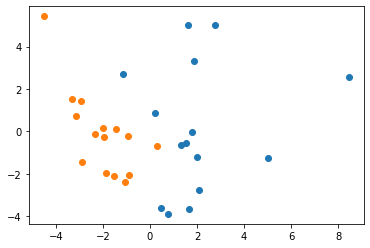

In [1336]:
plt.scatter(gp1[:,0], gp1[:,1])
plt.scatter(gp2[:,0], gp2[:,1])

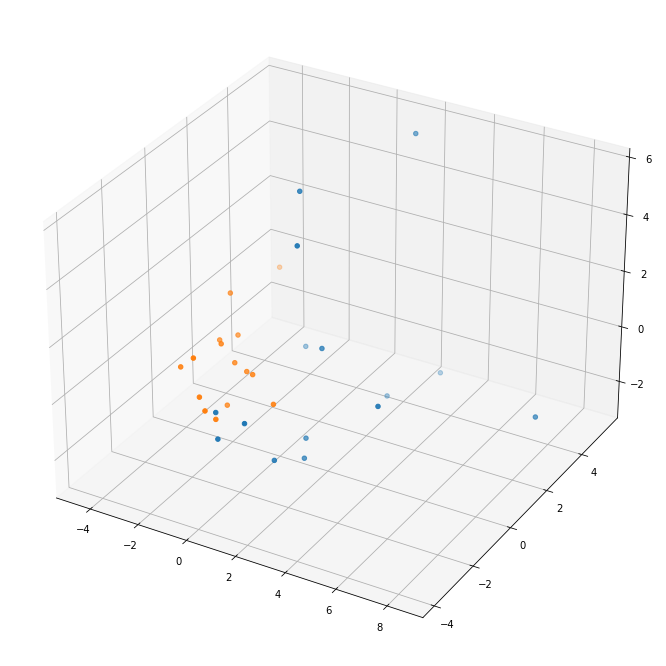

In [1339]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(gp1[:,0], gp1[:,1], gp1[:,2])
ax.scatter(gp2[:,0], gp2[:,1], gp2[:,2])
plt.show()

### VO2 Max vs Volume

In [1073]:
lvmc_df.shape

(34, 12)

In [1074]:
num_rows = lvmc_df.shape[0]
num_rows

34

'lvmc_snr', 'lv_std'

In [82]:
lvmc_df.head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_vol_ed,lv_vol_es,lv_std,lv_snr,stroke_volume,ejection_fraction
0,154,33.310077,12.961148,1618.0,1517.0,1618.0,1,0.195303,1911.0,680.0,118.003349,3.293070,1231.0,0.644165
1,109,29.950299,20.040120,1646.0,1536.0,1679.0,0,0.144133,2024.0,627.0,198.567112,2.417394,1397.0,0.690217
2,124,18.196760,29.820123,1718.0,1581.0,1718.0,1,0.097206,1521.0,802.0,71.457336,5.133858,719.0,0.472715
3,132,14.905681,34.009313,1717.0,1838.0,1950.0,0,0.119487,2324.0,1108.0,116.208079,4.570102,1216.0,0.523236
4,174,23.285652,25.611220,1541.0,1635.0,1647.0,0,0.092896,2014.0,875.0,161.210852,3.355029,1139.0,0.565541


In [83]:
u_test

[('lvmc_std', 0.3526160515425083),
 ('lvmc_snr', 0.29820363092917274),
 ('lvmc_vol_es', 0.12822922288082206),
 ('lvmc_vol_ed', 0.09920259781635354),
 ('lvmc_vol_max', 0.11017730081663768),
 ('lvmc_vol_es_equal_max', 0.3180834678338399),
 ('lvmc_vol_max_minus_min', 0.29820363092917274),
 ('lv_vol_ed', 0.12822922288082206),
 ('lv_vol_es', 0.2981835351857837),
 ('lv_std', 0.12822922288082206),
 ('lv_snr', 0.3414428246062309),
 ('stroke_volume', 0.14475295615752537),
 ('ejection_fraction', 0.4102272966927377)]

In [193]:
lv_vol_vo2_max = []
for n in range(num_rows):
    pid = lvmc_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    if not np.isnan(cpet_record['PetCO2'].values[0]):
        lv_vol_vo2_max.append((lvmc_df.iloc[n]['lv_vol_ed'],cpet_record['VO2 (MAX):'].values[0],\
                               cpet_record['dyspnea'].values[0],cpet_record['PetCO2'].values[0]))

In [181]:
plt_arr = lv_vol_vo2_max
dyspnea = [ent for ent in plt_arr if ent[2] == 1.]
normal = [ent for ent in plt_arr if ent[2] == 0.]

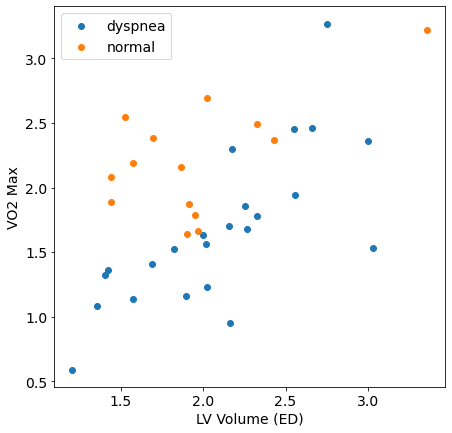

In [183]:
plt.figure(figsize=(7,7))
plt.xlabel('LV Volume (ED)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('VO2 Max',fontsize=14)
plt.yticks(fontsize=14)
dyspnea_x = [ent[0]/1000 for ent in dyspnea]
normal_x = [ent[0]/1000 for ent in normal]
dyspnea_y = [ent[1] for ent in dyspnea]
normal_y = [ent[1] for ent in normal]
plt.scatter(dyspnea_x,dyspnea_y,label='dyspnea')
plt.scatter(normal_x,normal_y,label='normal')
plt.legend(fontsize=14);

In [185]:
len(plt_arr)

37

In [190]:
#plt_arr = dyspnea
scipy.stats.pearsonr([ent[0]/1000 for ent in plt_arr],[ent[1] for ent in plt_arr])

(0.5443993361691567, 0.0004952985411498973)

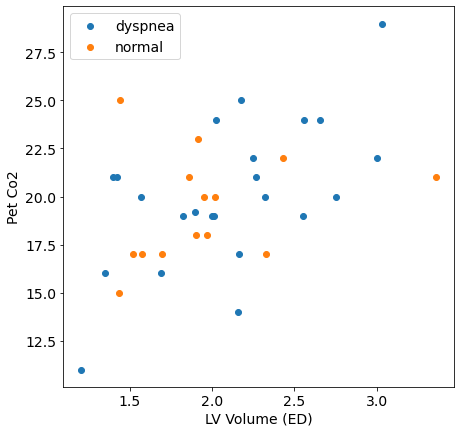

In [191]:
plt.figure(figsize=(7,7))
plt.xlabel('LV Volume (ED)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Pet Co2',fontsize=14)
plt.yticks(fontsize=14)
dyspnea_x = [ent[0]/1000 for ent in dyspnea]
normal_x = [ent[0]/1000 for ent in normal]
dyspnea_y = [ent[3] for ent in dyspnea]
normal_y = [ent[3] for ent in normal]
plt.scatter(dyspnea_x,dyspnea_y,label='dyspnea')
plt.scatter(normal_x,normal_y,label='normal')
plt.legend(fontsize=14);

In [192]:
#plt_arr = dyspnea
scipy.stats.pearsonr([ent[0]/1000 for ent in plt_arr],[ent[3] for ent in plt_arr])

(0.48714636888700386, 0.0022295125530345846)

In [195]:
lv_vol_vo2_max = []
for n in range(num_rows):
    pid = lvmc_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    lv_vol_vo2_max.append((lvmc_df.iloc[n]['lv_vol_ed'],cpet_record['VO2 (MAX):'].values[0],\
                               cpet_record['dyspnea'].values[0],cpet_record['PetCO2'].values[0]))

In [196]:
len(lv_vol_vo2_max)

38

In [197]:
lvmc_df['pkvo2'] = [ent[1] for ent in lv_vol_vo2_max]

In [198]:
lvmc_df.head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_vol_ed,lv_vol_es,lv_std,lv_snr,stroke_volume,ejection_fraction,pkvo2
0,154,33.310077,12.961148,1618.0,1517.0,1618.0,1,0.195303,1911.0,680.0,118.003349,3.293070,1231.0,0.644165,1.87
1,109,29.950299,20.040120,1646.0,1536.0,1679.0,0,0.144133,2024.0,627.0,198.567112,2.417394,1397.0,0.690217,1.23
2,124,18.196760,29.820123,1718.0,1581.0,1718.0,1,0.097206,1521.0,802.0,71.457336,5.133858,719.0,0.472715,2.55
3,132,14.905681,34.009313,1717.0,1838.0,1950.0,0,0.119487,2324.0,1108.0,116.208079,4.570102,1216.0,0.523236,1.78
4,174,23.285652,25.611220,1541.0,1635.0,1647.0,0,0.092896,2014.0,875.0,161.210852,3.355029,1139.0,0.565541,1.56


In [199]:
u_test

[('lvmc_std', 0.3526160515425083),
 ('lvmc_snr', 0.29820363092917274),
 ('lvmc_vol_es', 0.12822922288082206),
 ('lvmc_vol_ed', 0.09920259781635354),
 ('lvmc_vol_max', 0.11017730081663768),
 ('lvmc_vol_es_equal_max', 0.3180834678338399),
 ('lvmc_vol_max_minus_min', 0.29820363092917274),
 ('lv_vol_ed', 0.12822922288082206),
 ('lv_vol_es', 0.2981835351857837),
 ('lv_std', 0.12822922288082206),
 ('lv_snr', 0.3414428246062309),
 ('stroke_volume', 0.14475295615752537),
 ('ejection_fraction', 0.4102272966927377)]

In [222]:
multivariate_x = lvmc_df[['lvmc_vol_max','lv_vol_ed','lv_std']]
multivariate_y = lvmc_df[['pkvo2']]

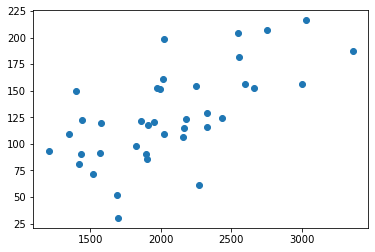

In [223]:
y = multivariate_x.lv_std.values
x = multivariate_x.lv_vol_ed.values
plt.scatter(x, y )

In [201]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


In [224]:
robust_scaled = RobustScaler().fit_transform(multivariate_x)
std_scaled = StandardScaler().fit_transform(multivariate_x)

In [225]:
robust_reg = LinearRegression().fit(robust_scaled, multivariate_y)
robust_reg.score(robust_scaled, multivariate_y)

0.31304050492507174

In [226]:
std_reg = LinearRegression().fit(std_scaled, multivariate_y)
std_reg.score(std_scaled, multivariate_y)

0.3130405049250716

In [227]:
std_reg.coef_

array([[ 0.03885092,  0.34158413, -0.07169102]])

In [228]:
robust_scaled.shape

(38, 3)

In [229]:
data = pd.DataFrame({'x0': robust_scaled[:,0], 'x1': robust_scaled[:,1], 'x2': robust_scaled[:,2], \
                     #'x3': robust_scaled[:,3], 'x4': robust_scaled[:,4], 'x5': robust_scaled[:,5], \
                     'y': multivariate_y.pkvo2.values})

In [230]:
model = ols("y ~ x0 + x1 + x2 ", data).fit()

In [231]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     5.164
Date:                Wed, 18 May 2022   Prob (F-statistic):            0.00476
Time:                        11:41:45   Log-Likelihood:                -26.638
No. Observations:                  38   AIC:                             61.28
Df Residuals:                      34   BIC:                             67.83
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8475      0.085     21.753      0.0

In [232]:
anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)


ANOVA results
            df    sum_sq   mean_sq         F    PR(>F)
x0         1.0  2.484682  2.484682  9.344652  0.004335
x1         1.0  1.522156  1.522156  5.724681  0.022398
x2         1.0  0.112772  0.112772  0.424124  0.519264
Residual  34.0  9.040380  0.265894       NaN       NaN


In [1085]:
plt_arr = normal
scipy.stats.pearsonr(plt_arr[:,0]/1000,plt_arr[:,1])

(0.5934409160521241, 0.03251185130319946)

In [745]:
lvmc_vol_vo2_max = np.zeros((num_rows,3))
for n in range(num_rows):
    lvmc_vol_vo2_max[n,0] = shape_df.iloc[n]['lvmc_vol_es']
    pid = shape_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    lvmc_vol_vo2_max[n,1] = cpet_record['VO2 (MAX):']
    lvmc_vol_vo2_max[n,2] = cpet_record['dyspnea']
    

In [30]:
lvmc_vol_vo2_max_cp = np.delete(lvmc_vol_vo2_max,16,0)
#lvmc_vol_vo2_max_cp

In [746]:
plt_arr = lvmc_vol_vo2_max
dyspnea = plt_arr[plt_arr[:,2] == 1.]
normal = plt_arr[plt_arr[:,2] == 0.]

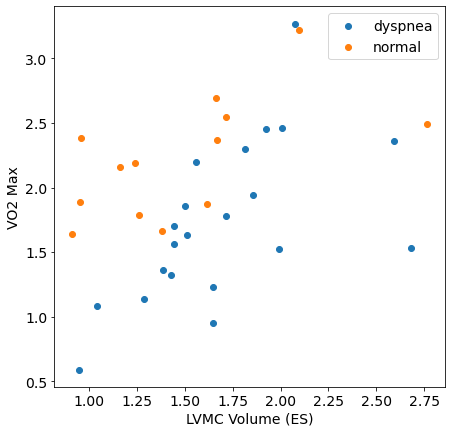

In [747]:
plt.figure(figsize=(7,7))
plt.xlabel('LVMC Volume (ES)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('VO2 Max',fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(dyspnea[:,0]/1000,dyspnea[:,1],label='dyspnea')
plt.scatter(normal[:,0]/1000,normal[:,1],label='normal')
plt.legend(fontsize=14);

In [748]:
#plt_arr = dyspnea
scipy.stats.pearsonr(plt_arr[:,0]/1000,plt_arr[:,1])

(0.42963928958424413, 0.01121730578117901)

In [34]:
plt_arr = normal
scipy.stats.pearsonr(plt_arr[:,0]/1000,plt_arr[:,1])

(0.6519016957704744, 0.021613654480319384)

In [37]:
weight_vo2_max_cp = np.delete(weight_vo2_max,16,0)
#weight_vo2_max_cp

In [38]:
plt_arr = weight_vo2_max_cp
dyspnea = plt_arr[plt_arr[:,2] == 1.]
normal = plt_arr[plt_arr[:,2] == 0.]

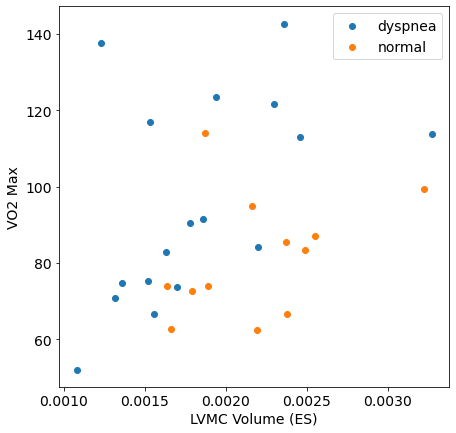

In [39]:
plt.figure(figsize=(7,7))
plt.xlabel('LVMC Volume (ES)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('VO2 Max',fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(dyspnea[:,0]/1000,dyspnea[:,1],label='dyspnea')
plt.scatter(normal[:,0]/1000,normal[:,1],label='normal')
plt.legend(fontsize=14);

In [40]:
plt_arr = dyspnea
scipy.stats.pearsonr(plt_arr[:,0]/1000,plt_arr[:,1])

(0.49208694373229084, 0.044804615138186725)

In [41]:
plt_arr = normal
scipy.stats.pearsonr(plt_arr[:,0]/1000,plt_arr[:,1])

(0.35257163669970415, 0.26099141416588084)

In [42]:
for n in range(num_rows//2):
    ed_vol = shape_df_ed.iloc[n]['lv_volume']
    es_vol = shape_df_es.iloc[n]['lv_volume']
    assert(ed_vol > es_vol)

In [301]:
dyspnea_vol = []
normal_vol = []

for n in range(num_rows//2):
    vol = shape_df_ed.iloc[n]['lv_volume']
    pid = shape_df_ed.iloc[n]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_vol.append(vol/1000)
    else:
        normal_vol.append(vol/1000)

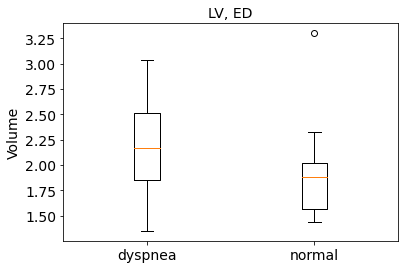

In [302]:
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('LV, ED',fontsize = 14)
plt.ylabel('Volume',fontsize=14)
plt.boxplot([dyspnea_vol, normal_vol], labels=['dyspnea','normal']);

In [303]:
scipy.stats.mannwhitneyu(dyspnea_vol,normal_vol)

MannwhitneyuResult(statistic=76.0, pvalue=0.09118366909157816)

In [43]:
dyspnea_vol = []
normal_vol = []

for n in range(num_rows//2):
    vol = shape_df_es.iloc[n]['lvmc_volume']
    pid = shape_df_es.iloc[n]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_vol.append(vol/1000)
    else:
        normal_vol.append(vol/1000)

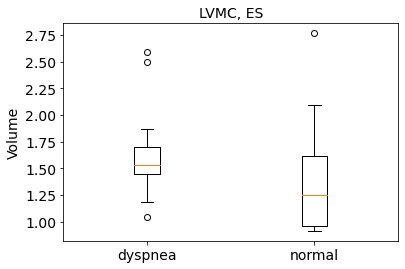

In [44]:
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('LVMC, ES',fontsize = 14)
plt.ylabel('Volume',fontsize=14)
plt.boxplot([dyspnea_vol, normal_vol], labels=['dyspnea','normal']);

In [45]:
scipy.stats.mannwhitneyu(dyspnea_vol,normal_vol)

MannwhitneyuResult(statistic=66.0, pvalue=0.03947296104086789)

In [308]:
len(normal_vol)

12

In [316]:
dyspnea_vol = []
normal_vol = []
dyspnea_vo2_max = []
normal_vo2_max = []

for n in range(num_rows//2):
    vol = shape_df_ed.iloc[n]['lv_volume']
    pid = shape_df_ed.iloc[n]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_vol.append(vol/1000)
        dyspnea_vo2_max.append(cpet_record['VO2 (MAX):'].values[0])
    else:
        normal_vol.append(vol/1000)
        normal_vo2_max.append(cpet_record['VO2 (MAX):'].values[0])

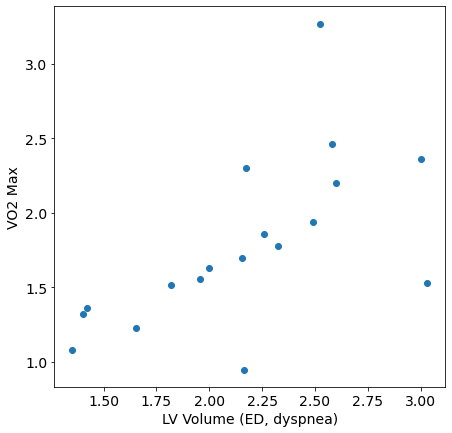

In [317]:
plt.figure(figsize=(7,7))
plt.xlabel('LV Volume (ED, dyspnea)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('VO2 Max',fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(dyspnea_vol,dyspnea_vo2_max);

In [318]:
scipy.stats.pearsonr(dyspnea_vol,dyspnea_vo2_max)

(0.6125340176661966, 0.00688427605434426)

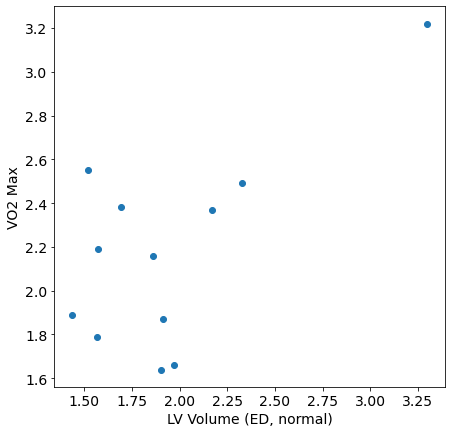

In [319]:
plt.figure(figsize=(7,7))
plt.xlabel('LV Volume (ED, normal)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('VO2 Max',fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(normal_vol,normal_vo2_max);

In [320]:
scipy.stats.pearsonr(normal_vol,normal_vo2_max)

(0.6591821031756754, 0.019718651219138756)

In [151]:
dyspnea_weight = []
normal_weight = []

for n in range(num_rows//2):
    pid = shape_df_ed.iloc[n]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    weight = cpet_record['Weight (kg):']
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_weight.append(weight.values[0])
    else:
        normal_weight.append(weight.values[0])

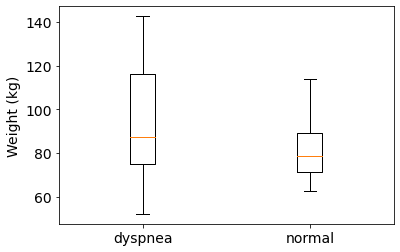

In [295]:
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.title('LV, ED',fontsize = 14)
plt.ylabel('Weight (kg)',fontsize=14)
plt.boxplot([dyspnea_weight, normal_weight], labels=['dyspnea','normal']);

In [199]:
scipy.stats.mannwhitneyu(dyspnea_weight, normal_weight)

MannwhitneyuResult(statistic=75.0, pvalue=0.08441270902697046)

In [153]:
dyspnea_age = []
normal_age = []

for n in range(num_rows//2):
    pid = shape_df_ed.iloc[n]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    age = cpet_record['Age:']
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_age.append(age.values[0])
    else:
        normal_age.append(age.values[0])

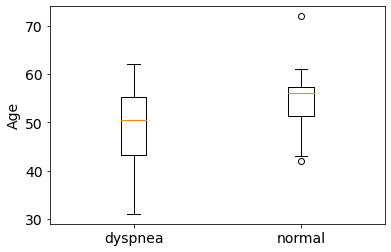

In [296]:
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.title('LV, ED',fontsize = 14)
plt.ylabel('Age',fontsize=14)
plt.boxplot([dyspnea_age, normal_age], labels=['dyspnea','normal']);

In [200]:
scipy.stats.mannwhitneyu(dyspnea_age, normal_age)

MannwhitneyuResult(statistic=71.5, pvalue=0.06335158055604118)

In [158]:
dyspnea_vol = []
normal_vol = []

for n in range(num_rows//2):
    vol = shape_df_es.iloc[n]['lvmc_volume']
    pid = shape_df_es.iloc[n]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_vol.append(vol)
    else:
        normal_vol.append(vol)

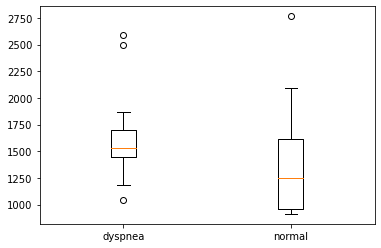

In [159]:
plt.boxplot([dyspnea_vol, normal_vol], labels=['dyspnea','normal']);

In [160]:
scipy.stats.median_test(dyspnea_vol,normal_vol)

(1.25,
 0.26355247728296954,
 1491.0,
 array([[11,  4],
        [ 7,  8]]))

In [191]:
dyspnea_arr = []
normal_arr = []

for n in range(num_rows//2):
    arr = shape_df_es.iloc[n]['lv_avg_average_radial_ratio']
    pid = shape_df_es.iloc[n]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    condition = cpet_record['dyspnea']
    if condition.values[0] == 1.:
        dyspnea_arr.append(arr)
    else:
        normal_arr.append(arr)

In [192]:
scipy.stats.median_test(dyspnea_arr,normal_arr)

(0.1388888888888889,
 0.7093881150142264,
 0.8511225,
 array([[ 8,  7],
        [10,  5]]))

In [193]:
#plt_arr = weight_vo2_max_cp
scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)

MannwhitneyuResult(statistic=101.0, pvalue=0.3915939917709921)

In [12]:
shape_df_ed.drop(columns=['PatientId','MaskType','Phase']).describe().T

,count,mean,std,min,25%,50%,75%,max
0,,,,,,,,
lv_avg_average_radial_ratio,23.0,0.873120,0.015359,0.847201,0.860400,0.874271,0.883880,0.902945
lv_std_average_radial_ratio,23.0,0.033098,0.014026,0.013750,0.025910,0.030022,0.036303,0.071577
lv_avg_area_overlap_ratio,23.0,0.838607,0.032090,0.778204,0.824306,0.838937,0.865976,0.899609
lv_std_area_overlap_ratio,23.0,0.054358,0.016336,0.026265,0.045832,0.053678,0.059949,0.101293
lv_avg_compactness,23.0,12.975280,0.251626,12.357194,12.832362,12.952883,13.189454,13.372891
lv_std_compactness,23.0,0.446043,0.301783,0.154380,0.280636,0.342986,0.503009,1.510453
lv_avg_convexity,23.0,0.966218,0.002750,0.960827,0.963850,0.966812,0.968524,0.970908
lv_std_convexity,23.0,0.006440,0.002144,0.003069,0.004748,0.006302,0.008205,0.010651
lv_avg_Hausdorff_Dimension,23.0,0.943794,0.047400,0.822956,0.932483,0.946178,0.973729,1.045217


In [13]:
shape_df_es.drop(columns=['PatientId','MaskType','Phase']).describe().T

,count,mean,std,min,25%,50%,75%,max
0,,,,,,,,
lv_avg_average_radial_ratio,23.0,0.844460,0.025769,0.784607,0.835111,0.851005,0.859689,0.887758
lv_std_average_radial_ratio,23.0,0.037496,0.022601,0.009499,0.022478,0.035217,0.041896,0.113961
lv_avg_area_overlap_ratio,23.0,0.820595,0.050970,0.698145,0.795209,0.821979,0.855881,0.907986
lv_std_area_overlap_ratio,23.0,0.066648,0.034469,0.021176,0.039109,0.060824,0.087786,0.151843
lv_avg_compactness,23.0,12.523833,0.440738,11.490716,12.225852,12.522297,12.818109,13.546399
lv_std_compactness,23.0,0.684121,0.423024,0.222257,0.340817,0.646717,0.875290,2.015103
lv_avg_convexity,23.0,0.971609,0.004359,0.961209,0.968950,0.972193,0.975024,0.978671
lv_std_convexity,23.0,0.009124,0.003637,0.002481,0.006733,0.008396,0.011547,0.016888
lv_avg_Hausdorff_Dimension,23.0,0.882744,0.073050,0.754645,0.832113,0.888959,0.930958,1.055450


In [368]:
#pyradiomics_df.to_csv('pyradiomics.csv')

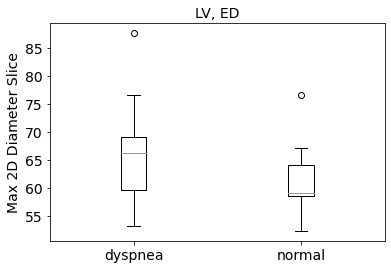

In [488]:
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('LV, ED',fontsize = 14)
plt.ylabel('Max 2D Diameter Slice',fontsize=14)
plt.boxplot([dyspnea_arr,normal_arr], labels=['dyspnea','normal']);

In [483]:
dia_slice_2d_vo2_max = np.zeros((num_rows//2,3))
for n in range(num_rows//2):
    dia_slice_2d_vo2_max[n,0] = pyradiomics_df.iloc[n]['original_shape_Maximum2DDiameterSlice']
    pid = pyradiomics_df.iloc[n]['PatientId']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    dia_slice_2d_vo2_max[n,1] = cpet_record['VO2 (MAX):']
    dia_slice_2d_vo2_max[n,2] = cpet_record['dyspnea']
    

In [484]:
dia_slice_2d_vo2_max = np.delete(dia_slice_2d_vo2_max,16,0)
dia_slice_2d_vo2_max

array([[69.16104395,  2.36      ,  1.        ],
       [66.15984432,  1.52      ,  1.        ],
       [63.94883208,  1.23      ,  1.        ],
       [58.65817292,  2.38      ,  0.        ],
       [52.30394942,  2.55      ,  0.        ],
       [68.00965005,  2.2       ,  1.        ],
       [63.3729043 ,  2.49      ,  0.        ],
       [59.56469697,  1.7       ,  1.        ],
       [67.5519476 ,  1.78      ,  1.        ],
       [58.75425517,  2.3       ,  1.        ],
       [58.65817292,  2.19      ,  0.        ],
       [59.375     ,  1.66      ,  0.        ],
       [60.69042861,  1.56      ,  1.        ],
       [62.47649558,  1.63      ,  1.        ],
       [54.26238338,  1.89      ,  0.        ],
       [68.00965005,  3.27      ,  1.        ],
       [73.73982981,  2.46      ,  1.        ],
       [87.61786704,  1.86      ,  1.        ],
       [66.15984432,  1.64      ,  0.        ],
       [53.10661447,  1.36      ,  1.        ],
       [67.17514421,  1.79      ,  0.   

In [485]:
plt_arr = dia_slice_2d_vo2_max
dyspnea = plt_arr[plt_arr[:,2] == 1.]
normal = plt_arr[plt_arr[:,2] == 0.]

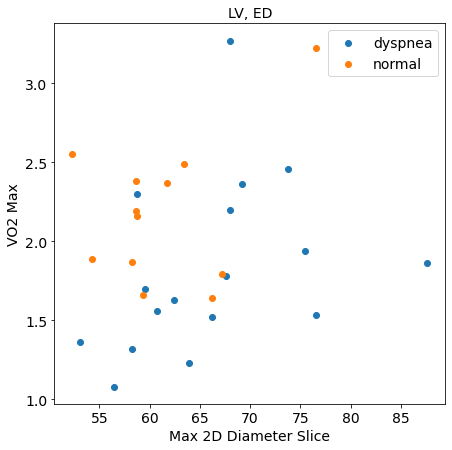

In [493]:
plt.figure(figsize=(7,7))
plt.xlabel('Max 2D Diameter Slice',fontsize=14)
plt.xticks(fontsize=14)
plt.title('LV, ED',fontsize = 14)
plt.ylabel('VO2 Max',fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(dyspnea[:,0],dyspnea[:,1],label='dyspnea')
plt.scatter(normal[:,0],normal[:,1],label='normal')
plt.legend(fontsize=14);

In [492]:
scipy.stats.pearsonr(dia_slice_2d_vo2_max[:,0],dia_slice_2d_vo2_max[:,1])

(0.2153229534385954, 0.26196222038926753)

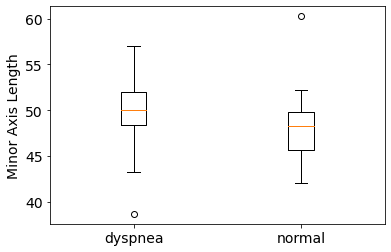

In [963]:
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.title('LV, ED',fontsize = 14)
plt.ylabel('Minor Axis Length',fontsize=14)
plt.boxplot([dyspnea_arr,normal_arr], labels=['dyspnea','normal']);

In [14]:
lv_avg_cols = ['lv_avg_average_radial_ratio', 'lv_avg_area_overlap_ratio','lv_avg_compactness',\
                      'lv_avg_convexity', 'lv_avg_Hausdorff_Dimension', 'lv_avg_smoothness', \
                     'lv_avg_std_distance_ratio']

In [15]:
lv_avg_ed_df = shape_df_ed[lv_avg_cols]
lv_avg_es_df = shape_df_es[lv_avg_cols]

In [88]:
#scaler = StandardScaler()
scaler = RobustScaler()
lv_avg_ed_scaled = scaler.fit_transform(lv_avg_ed_df)
lv_avg_es_scaled = scaler.fit_transform(lv_avg_es_df)

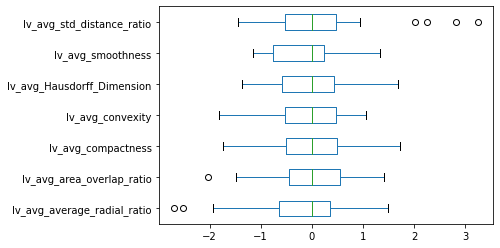

In [98]:
lv_avg_es_scaled_df = pd.DataFrame(lv_avg_es_scaled, columns=lv_avg_cols)
boxplot = lv_avg_es_scaled_df.boxplot(column=lv_avg_cols,vert=False, grid=False)  

In [39]:
shape_df_es[['PatientId','lv_avg_std_distance_ratio']]

,PatientId,lv_avg_std_distance_ratio
2,101B,0.072192
4,103,0.082624
6,124,0.080462
8,126,0.070372
10,129,0.092574
12,130,0.073770
14,132,0.080499
16,151,0.058070
18,181,0.069356
20,157,0.078255


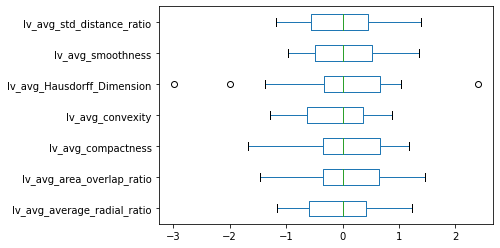

In [104]:
lv_avg_ed_scaled_df = pd.DataFrame(lv_avg_ed_scaled, columns=lv_avg_cols)
boxplot = lv_avg_ed_scaled_df.boxplot(column=lv_avg_cols,vert=False, grid=False)  

In [55]:
shape_df_ed[['PatientId','lv_avg_Hausdorff_Dimension']]

,PatientId,lv_avg_Hausdorff_Dimension
1,101B,0.931873
3,103,1.045217
5,124,0.952106
7,126,0.988526
9,129,0.974834
11,130,0.946178
13,132,0.957882
15,151,0.944894
17,181,0.948040
19,157,0.945056


In [56]:
lv_std_cols = ['lv_std_average_radial_ratio', 'lv_std_area_overlap_ratio','lv_std_compactness',\
                      'lv_std_convexity', 'lv_std_Hausdorff_Dimension', 'lv_std_smoothness', \
                     'lv_std_std_distance_ratio']

In [57]:
lv_std_ed_df = shape_df_ed[lv_std_cols]
lv_std_es_df = shape_df_es[lv_std_cols]

In [91]:
lv_std_ed_scaled = scaler.fit_transform(lv_std_ed_df)
lv_std_es_scaled = scaler.fit_transform(lv_std_es_df)

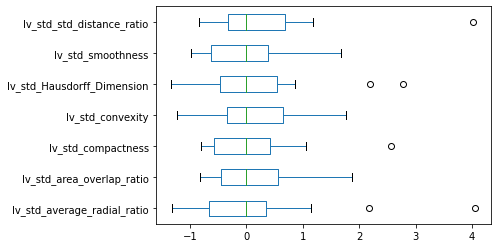

In [92]:
lv_std_es_scaled_df = pd.DataFrame(lv_std_es_scaled, columns=lv_std_cols)
boxplot = lv_std_es_scaled_df.boxplot(column=lv_std_cols,vert=False, grid=False)  

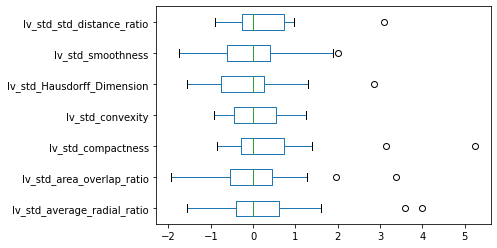

In [93]:
lv_std_ed_scaled_df = pd.DataFrame(lv_std_ed_scaled, columns=lv_std_cols)
boxplot = lv_std_ed_scaled_df.boxplot(column=lv_std_cols,vert=False, grid=False)  

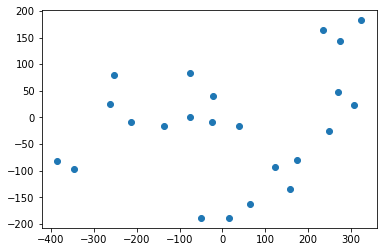

In [132]:
scaled = lv_avg_ed_scaled
embedded = TSNE(n_components=2, perplexity = 5, random_state=0).fit_transform(scaled)
plt.scatter(embedded[:,0],embedded[:,1])

In [133]:
embedded

array([[ -22.23164  ,   40.806973 ],
       [ 323.49338  ,  182.45941  ],
       [ 174.0287   ,  -80.03773  ],
       [ 268.17627  ,   48.194405 ],
       [-253.03668  ,   78.82509  ],
       [ 123.443474 ,  -93.41834  ],
       [  38.07096  ,  -16.812174 ],
       [ 158.04272  , -135.37299  ],
       [ 306.83304  ,   23.371426 ],
       [ -75.0662   ,    1.1128023],
       [ -23.766884 ,   -9.1060295],
       [  63.115864 , -162.06796  ],
       [ -75.827576 ,   83.7204   ],
       [-345.83884  ,  -96.60039  ],
       [-262.88272  ,   24.924137 ],
       [ 247.15112  ,  -24.972754 ],
       [ 233.75648  ,  164.97777  ],
       [-214.26303  ,   -8.234299 ],
       [-136.22383  ,  -16.665089 ],
       [  16.071075 , -188.73996  ],
       [ -50.1382   , -188.80154  ],
       [-385.85614  ,  -81.63168  ],
       [ 273.25714  ,  143.1324   ]], dtype=float32)

In [130]:
scaled = lv_avg_ed_scaled
embedded = TSNE(n_components=2, perplexity = 6, random_state=0).fit_transform(scaled)
plt.scatter(embedded[:,0],embedded[:,1])

NameError: name 'lv_avg_ed_scaled' is not defined

In [137]:
lv_avg_ed_scaled_embedded

array([[-140.68652  ,  219.94722  ],
       [ 452.5178   , -234.08109  ],
       [  10.095922 ,  482.9768   ],
       [ 296.30017  , -389.56082  ],
       [  -3.5928395,  -58.696964 ],
       [ -73.66328  ,  440.68094  ],
       [ -61.424145 ,  136.45601  ],
       [ -76.18109  ,  538.896    ],
       [ 212.07668  , -369.22244  ],
       [  32.277576 ,  197.48123  ],
       [ -55.41921  ,  244.9977   ],
       [-223.43378  ,  456.4548   ],
       [-229.98439  ,  135.96057  ],
       [-272.41013  , -100.46626  ],
       [  86.10283  , -100.36261  ],
       [ 218.63113  , -494.22162  ],
       [ 305.3009   , -168.67995  ],
       [ 188.56299  ,  -59.31162  ],
       [ 148.77293  ,   93.50984  ],
       [-307.69702  ,  402.93817  ],
       [-354.067    ,  287.8924   ],
       [-296.70844  , -174.42049  ],
       [ 339.10745  , -243.71487  ]], dtype=float32)

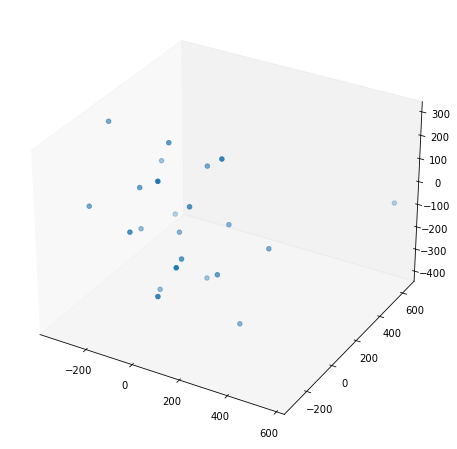

In [80]:
lv_avg_ed_scaled_embedded = TSNE(n_components=3, perplexity = 6, random_state=0).fit_transform(lv_avg_ed_scaled)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(lv_avg_ed_scaled_embedded[:,0],lv_avg_ed_scaled_embedded[:,1],lv_avg_ed_scaled_embedded[:,2])
ax.grid(False)
plt.show()

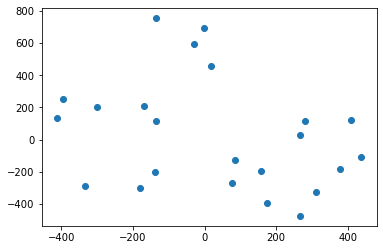

In [122]:
lv_std_ed_scaled_embedded = TSNE(n_components=2, perplexity = 6, random_state=0).fit_transform(lv_std_ed_scaled)
plt.scatter(lv_std_ed_scaled_embedded[:,0],lv_std_ed_scaled_embedded[:,1])

In [123]:
lv_std_ed_scaled_embedded

array([[-139.27818  , -204.17165  ],
       [ 310.14246  , -325.7981   ],
       [-394.89285  ,  250.41673  ],
       [-168.27257  ,  207.39572  ],
       [ 158.01334  , -193.70425  ],
       [ -29.880255 ,  594.0128   ],
       [  16.525404 ,  457.60718  ],
       [  -1.3119798,  696.1369   ],
       [  76.47993  , -267.37335  ],
       [ 378.16907  , -182.54932  ],
       [ 172.76617  , -395.45392  ],
       [-298.94943  ,  204.83379  ],
       [-332.46613  , -286.15518  ],
       [-181.66838  , -298.94617  ],
       [ 267.32272  ,   27.850304 ],
       [-134.97437  ,  116.00632  ],
       [ 280.04727  ,  117.91208  ],
       [ 409.6072   ,  123.036514 ],
       [ 266.74786  , -474.22928  ],
       [  83.87576  , -123.64928  ],
       [-134.67921  ,  754.2854   ],
       [-412.17975  ,  136.04486  ],
       [ 437.25983  , -105.27056  ]], dtype=float32)

In [124]:
shape_df_ed[['PatientId','lv_std_average_radial_ratio']]

,PatientId,lv_std_average_radial_ratio
1,101B,0.034341
3,103,0.033120
5,124,0.013750
7,126,0.019282
9,129,0.028947
11,130,0.046720
13,132,0.037524
15,151,0.044044
17,181,0.027505
19,157,0.034945


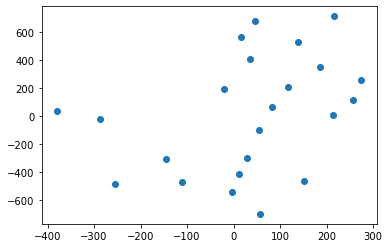

In [20]:
lv_avg_es_scaled_embedded = TSNE(n_components=2, perplexity = 8, random_state=0).fit_transform(lv_avg_es_scaled)
plt.scatter(lv_avg_es_scaled_embedded[:,0],lv_avg_es_scaled_embedded[:,1])

In [455]:
lv_std_ed_df = shape_df_ed[lv_std_cols]

In [456]:
lv_std_ed_scaled = scaler.fit_transform(lv_std_ed_df)

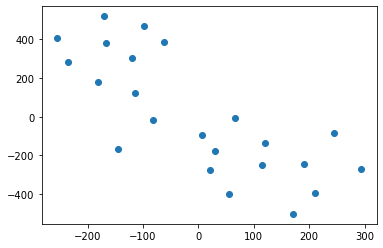

In [460]:
lv_std_ed_scaled_embedded = TSNE(n_components=2, perplexity = 8, random_state=0).fit_transform(lv_std_ed_scaled)
plt.scatter(lv_std_ed_scaled_embedded[:,0],lv_std_ed_scaled_embedded[:,1])

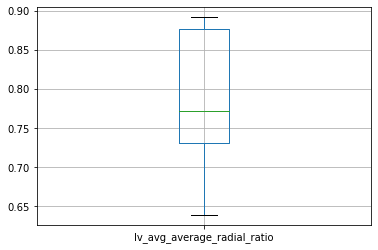

In [70]:
boxplot = shape_df_ed.boxplot(column='lv_avg_average_radial_ratio')

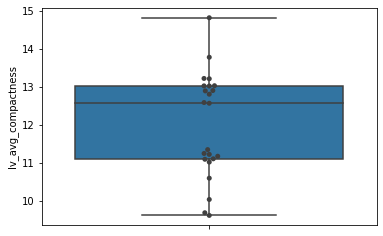

In [83]:
ax = sns.boxplot(y=shape_df_ed['lv_avg_compactness'])
ax = sns.swarmplot(y=shape_df_ed['lv_avg_compactness'],color=".25")